## Automatic Urban Sound Classification with CNN

**Background**

The automatic classification of environmental sound is a growing research field with multiple applications to largescale, content-based multimedia indexing and retrieval. In particular, the sonic analysis of urban environments is the subject of increased interest, partly enabled by multimedia sensor networks, as well as by large quantities of online multimedia content depicting urban scenes.

**Challenges**

There are primarily two major challenges with urban sound research namely

Lack of labeled audio data. Previous work has focused on audio from carefully produced movies or television tracks from specific environments such as elevators or office spaces and on commercial or proprietary datasets .

Lack of common vocabulary when working on urban sounds.This means the classification of sounds into semantic groups may vary from study to study, making it hard to compare results so the objective of this notebook is to address the above two mentioned challenges.

**Dataset**

The dataset is called UrbanSound and contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: - The dataset contains 8732 sound excerpts (<=4s) of urban sounds from 10 classes, namely: Air Conditioner Car Horn Children Playing Dog bark Drilling Engine Idling Gun Shot Jackhammer Siren Street Music The attributes of data are as follows: ID – Unique ID of sound excerpt Class – type of sound


**Objective**

The objective of this notebook is train a CNN model that will automate classification Urban sounds. 


**Note:** Loading audio files and pre-processsing takes some times to complete with large dataset. To avoid reload everytime reset the kernel or resume works on next day, all loaded audio data will be serialized into a object file. so next round only need to load the seriazed object file.   


Optional GPU configuration initialization

In [1]:
# GPU memory wizardry to avoid out of memory when using tensorflow-GPU as Keras backend
# remove this part of using CPU only version of tensorflow. 
import tensorflow as tf
from keras import backend as k
config = tf.ConfigProto()                                   # Set GPU options for tensorflow GPU 
config.gpu_options.allow_growth = True                      # Don't pre-allocate memory; allocate as-needed
config.gpu_options.per_process_gpu_memory_fraction = 0.8    # Only allow a total of half the GPU memory to be allocated
k.tensorflow_backend.set_session(tf.Session(config=config)) # Create a session with the above options specified.

Using TensorFlow backend.


Import libraries

In [2]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

#object serialization
import _pickle as cPickle  #python 3 change
import os  

%matplotlib inline

In [3]:
#enable memory profiler for memory management usage %%memit 
from memory_profiler import memory_usage
%load_ext memory_profiler

#enable garbage collection control
import gc
gc.enable()

In [164]:
#progress tracker
from tqdm import tqdm, tqdm_notebook

Audio file loading control flag

In [5]:
# when set to TRUE, training data get loaded from a saved serialized data object file 
# All audio files data get saved to a serialized object file to save reloading time on training runs 
#
# Note: 
# On first time run, if serialized file doesn't exist, this flag will get overrident 
#
SKIP_AUDIO_RELOAD = True


####  Dataset exploration

In [6]:
#location of the sound files
INPUT_PATH='./dataset/urban-sound-classification/input'

TRAIN_INPUT=INPUT_PATH+'/train'
TRAIN_AUDIO_DIR=TRAIN_INPUT+'/Train'

TEST_INPUT=INPUT_PATH+'/test'
TEST_AUDIO_DIR=TEST_INPUT+'/Test'

In [7]:
def load_input_data(pd, filepath):
    # Read Data
    data = pd.read_csv(filepath)
    #show_data_info(data)
    return data
    
def show_data_info(data):
    print ("***Data shape***")
    print ("-----------------------------------------------------")
    print (data.shape)
    print ("\n***Data Info***")
    print ("-----------------------------------------------------")
    print (data.info())
    print ("\n***Data description***")
    print ("-----------------------------------------------------")    
    print (data.describe())
    print ("\n***Record count***")
    print ("-----------------------------------------------------")    
    print (data.count())
    print ("\n***Top Records***")
    print ("-----------------------------------------------------")
    print (data.head(5))   
    print ("\n***Column with missing record***")
    print ("-----------------------------------------------------")    
    print (data.isnull().sum())
    print (data.columns[data.isnull().any()])
    #[col for col in df.columns if df[col].isnull().any()]
    print ("\n***All missing value in dataframe***")
    print ("-----------------------------------------------------")    
    print (data.isnull().values.any())
    print (data.isnull().sum().sum())


In [8]:
# training file
TRAIN_FILE=TRAIN_INPUT+'/train.csv'

#show info
train_input=load_input_data(pd,TRAIN_FILE)
train_input.head()

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark


In [9]:
# training file
TEST_FILE=TEST_INPUT+'/test.csv'

#show info
test_input=load_input_data(pd,TEST_FILE)
test_input.head()

,ID
0,5
1,7
2,8
3,9
4,13


In [10]:
#labels
valid_train_label = train_input[['Class']]
#x=data['label'].unique()
valid_train_label.count()

#unique classes
x = train_input.groupby('Class')['Class'].count()
x

Class
air_conditioner     600
car_horn            306
children_playing    600
dog_bark            600
drilling            600
engine_idling       624
gun_shot            230
jackhammer          668
siren               607
street_music        600
Name: Class, dtype: int64

In [11]:
# train data size
valid_train_data = train_input[['ID', 'Class']] 
valid_train_data.count()

ID       5435
Class    5435
dtype: int64

In [12]:
# test data size
valid_test_data = test_input[['ID']] 
valid_test_data.count()

ID    3297
dtype: int64

**Check input audio file samples**

In [13]:
# sample-1 load
sample1=TRAIN_AUDIO_DIR+'/943.wav'
duration=2.97 
sr=22050

y, sr = librosa.load(sample1, duration=duration,  sr=sr)
ps = librosa.feature.melspectrogram(y=y, sr=sr)

input_length=sr*duration
offset = len(y) - round(input_length)
print ("input:", round(input_length), " load:", len(y) , " offset:", offset)
print ("y shape:", y.shape, " melspec shape:", ps.shape)

input: 65489  load: 65489  offset: 0
y shape: (65489,)  melspec shape: (128, 128)


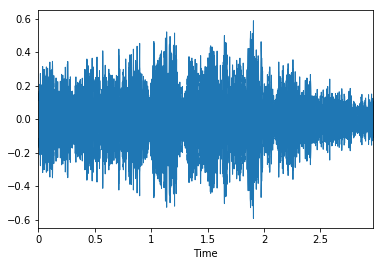

In [14]:
# sample-1 waveplot
librosa.display.waveplot(y,sr)

In [15]:
# sample-1: audio
import IPython.display as ipd
ipd.Audio(sample1) 

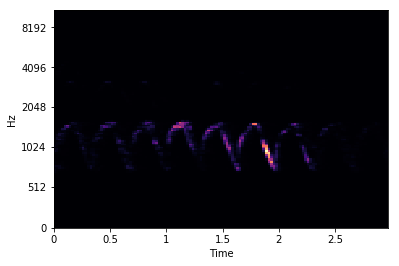

In [16]:
# sample-1: spectrogram
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [17]:
# sample-2 load
sample2=TRAIN_AUDIO_DIR+'/1.wav'
duration=2.97 
sr=22050

y2, sr2 = librosa.load(sample2, duration=duration,  sr=sr)
ps2 = librosa.feature.melspectrogram(y=y2, sr=sr2)

input_length=sr*duration
offset = len(y) - round(input_length)
print ("input:", round(input_length), " load:", len(y) , " offset:", offset)
print ("y shape:", y.shape, " melspec shape:", ps2.shape)

input: 65489  load: 65489  offset: 0
y shape: (65489,)  melspec shape: (128, 128)


In [18]:
# sample-2: audio
ipd.Audio(sample2) 

(128, 128)

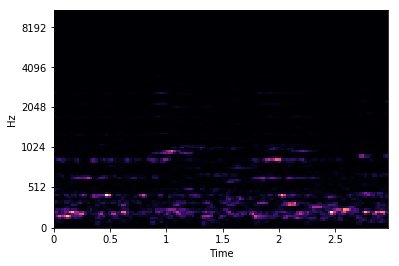

In [19]:
# sample-2: spectrogram
librosa.display.specshow(ps2, y_axis='mel', x_axis='time')
ps.shape

**Prepare data file loading**

In [20]:
#training audio files
valid_train_data['path'] = TRAIN_AUDIO_DIR+'/' + train_input['ID'].astype('str')+".wav"
print ("sample",valid_train_data.path[1])
valid_train_data.head(5)

sample ./dataset/urban-sound-classification/input/train/Train/1.wav


,ID,Class,path
0,0,siren,./dataset/urban-sound-classification/input/tra...
1,1,street_music,./dataset/urban-sound-classification/input/tra...
2,2,drilling,./dataset/urban-sound-classification/input/tra...
3,3,siren,./dataset/urban-sound-classification/input/tra...
4,4,dog_bark,./dataset/urban-sound-classification/input/tra...


In [21]:
#test audio files
valid_test_data['path'] = TEST_AUDIO_DIR+'/' + test_input['ID'].astype('str') +".wav"
print ("sample",valid_test_data.path[1])

valid_test_data.head(5)

sample ./dataset/urban-sound-classification/input/test/Test/7.wav


,ID,path
0,5,./dataset/urban-sound-classification/input/tes...
1,7,./dataset/urban-sound-classification/input/tes...
2,8,./dataset/urban-sound-classification/input/tes...
3,9,./dataset/urban-sound-classification/input/tes...
4,13,./dataset/urban-sound-classification/input/tes...


**Loading audio file and features**

In [22]:
#
# set duration on audio loading to make audio content to ensure each training data have same size
# 
# for instance, 3 seconds audio will have 128*128 which will be use on this notebook
#
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

#fix the load audio file size
audio_play_duration=2.97

def load_audio_file(file_path, duration=2.97, sr=22050):
    #load 5 seconds audio file, default 22 KHz default sr=22050
    # sr=resample to 16 KHz = 11025
    # sr=resample to 11 KHz = 16000
    # To preserve the native sampling rate of the file, use sr=None
    input_length=sr*duration
    # Load an audio file as a floating point time series.
    # y : np.ndarray [shape=(n,) or (2, n)] - audio time series
    # sr : number > 0 [scalar] - sampling rate of y
    y, sr = librosa.load(file_path,sr=sr, duration=duration)
    dur = librosa.get_duration(y=y)
    #pad output if audio file less than duration
    # Use edge-padding instead of zeros
    #librosa.util.fix_length(y, 10, mode='edge')
    if (round(dur) < duration):
        offset = len(y) - round(input_length)
        print ("fixing audio length :", file_path)
        print ("input:", round(input_length), " load:", len(y) , " offset:", offset)
        y = librosa.util.fix_length(y, round(input_length))      
    # y = audio_norm(y)
    # using a pre-computed power spectrogram
    # Short-time Fourier transform (STFT)
    #D = np.abs(librosa.stft(y))**2
    #ps = librosa.feature.melspectrogram(S=D)    
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    return ps

In [23]:
%%time
%%memit 
# Dataset
train_audio_data = [] 
train_object_file='saved_train_audio_data.p'

#override the reload flag if serized file doesn't exist
if not os.path.isfile(train_object_file):
    SKIP_AUDIO_RELOAD = False

#load training data
if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TRAINING data from audio files")
else:
    print ("loading train audio data, may take more than 15 minutes. please wait!")
    for row in tqdm(valid_train_data.itertuples()):
        ps = load_audio_file(file_path=row.path, duration=2.97)
        if ps.shape != (128, 128): continue
        train_audio_data.append( (ps, row.Class) ) 
    print("Number of train samples: ", len(train_audio_data))
# this step took sometime to finish    5382
#peak memory: 1141.30 MiB, increment: 642.16 MiB
#CPU times: user 15min 41s, sys: 14min 57s, total: 30min 39s

skip re-loading TRAINING data from audio files
skip re-loading TRAINING data from audio files
skip re-loading TRAINING data from audio files
skip re-loading TRAINING data from audio files
skip re-loading TRAINING data from audio files
skip re-loading TRAINING data from audio files
skip re-loading TRAINING data from audio files
peak memory: 951.77 MiB, increment: 0.55 MiB
CPU times: user 78.6 ms, sys: 85.6 ms, total: 164 ms
Wall time: 294 ms


In [24]:

# load saved audio object
if SKIP_AUDIO_RELOAD is True:
    train_audio_data = cPickle.load(open(train_object_file, 'rb'))
    print ("loaded train data [%s] records from object file" % len(train_audio_data))  
else:
    cPickle.dump(train_audio_data, open(train_object_file, 'wb')) 
    print ("saved loaded train data :",len(train_audio_data))

loaded train data [5382] records from object file


In [124]:
zx=np.zeros([128, 128])

zx.shape


(128, 128)

In [125]:
%%time
%%memit 
#load test data
test_audio_data = []
test_object_file='saved_test_audio_data.p'

#override the reload flag if serized file doesn't exist
if not os.path.isfile(test_object_file):
    SKIP_AUDIO_RELOAD = False

if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TEST data from audio files")
else:
    print ("loading test audio data, may take more than 15 minutes. please wait!")
    for row in tqdm(valid_test_data.itertuples()):
        ps = load_audio_file(file_path=row.path, duration=2.97)
        if ps.shape != (128, 128):
            print ("***data shape is wrong, replace it with zeros ", ps.shape, row.path)
            ps = np.zeros([128, 128])
            #continue
        test_audio_data.append( (ps, row.ID) ) 
    print("Number of train samples: ", len(train_audio_data))
    
# this step took sometime to finish    3251
#peak memory: 1586.96 MiB, increment: 445.65 MiB
#CPU times: user 9min 32s, sys: 9min 37s, total: 19min 10s 






0it [00:00, ?it/s]

loading test audio data, may take more than 15 minutes. please wait!







1it [00:00,  1.68it/s]




2it [00:00,  2.16it/s]




4it [00:00,  2.82it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8.wav
input: 65489  load: 45131  offset: -20358







5it [00:01,  3.52it/s]




6it [00:01,  2.79it/s]




7it [00:01,  3.39it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/14.wav
input: 65489  load: 44100  offset: -21389







8it [00:02,  2.88it/s]




9it [00:02,  2.65it/s]




10it [00:02,  3.17it/s]




11it [00:03,  2.77it/s]




13it [00:03,  3.57it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/29.wav
input: 65489  load: 19184  offset: -46305







14it [00:03,  2.95it/s]




15it [00:04,  2.66it/s]




16it [00:04,  2.34it/s]




17it [00:05,  2.85it/s]




18it [00:05,  3.48it/s]




19it [00:05,  4.16it/s]

***file shape is wrong, replace it with zeros  (128, 127) ./dataset/urban-sound-classification/input/test/Test/51.wav







20it [00:05,  4.84it/s]




21it [00:05,  3.58it/s]




23it [00:06,  4.74it/s]




24it [00:06,  3.49it/s]




25it [00:06,  4.01it/s]




26it [00:07,  3.29it/s]




27it [00:07,  3.88it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/73.wav
input: 65489  load: 38588  offset: -26901







28it [00:07,  3.11it/s]




29it [00:07,  3.73it/s]




30it [00:08,  4.53it/s]




31it [00:08,  3.15it/s]




32it [00:08,  3.77it/s]




33it [00:08,  4.56it/s]




34it [00:08,  5.33it/s]




35it [00:09,  6.00it/s]




36it [00:09,  3.98it/s]




37it [00:09,  3.19it/s]




38it [00:10,  3.82it/s]




39it [00:10,  4.60it/s]




40it [00:10,  3.51it/s]




41it [00:11,  2.88it/s]




42it [00:11,  3.48it/s]




43it [00:11,  4.21it/s]




44it [00:11,  3.26it/s]




45it [00:12,  2.90it/s]




46it [00:12,  3.52it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/124.wav
input: 65489  load: 50887  offset: -14602







47it [00:12,  4.29it/s]




48it [00:12,  4.98it/s]




49it [00:13,  3.18it/s]




50it [00:13,  3.73it/s]




51it [00:13,  4.38it/s]




52it [00:14,  3.27it/s]




53it [00:14,  2.83it/s]




54it [00:15,  2.53it/s]




55it [00:15,  2.21it/s]




56it [00:16,  2.19it/s]




57it [00:16,  2.74it/s]




58it [00:16,  3.38it/s]




59it [00:16,  2.89it/s]




60it [00:16,  3.49it/s]




61it [00:17,  2.97it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/161.wav
input: 65489  load: 25358  offset: -40131







63it [00:18,  3.11it/s]




64it [00:18,  3.70it/s]




65it [00:18,  4.40it/s]




67it [00:18,  5.33it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/173.wav
input: 65489  load: 48510  offset: -16979







68it [00:18,  6.13it/s]




69it [00:18,  6.49it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/181.wav
input: 65489  load: 48260  offset: -17229







70it [00:18,  6.85it/s]




71it [00:18,  7.53it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/191.wav
input: 65489  load: 36071  offset: -29418







72it [00:19,  4.28it/s]




73it [00:19,  3.31it/s]




74it [00:20,  2.89it/s]




75it [00:20,  3.35it/s]




77it [00:20,  4.24it/s]




78it [00:20,  4.82it/s]




79it [00:20,  5.37it/s]




80it [00:21,  6.04it/s]




81it [00:21,  3.94it/s]




82it [00:21,  4.50it/s]




83it [00:22,  3.71it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/210.wav
input: 65489  load: 10143  offset: -55346







84it [00:22,  3.07it/s]




85it [00:23,  2.46it/s]




86it [00:23,  2.34it/s]




87it [00:23,  2.90it/s]




88it [00:23,  3.54it/s]




89it [00:23,  4.32it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/240.wav
input: 65489  load: 20948  offset: -44541







91it [00:24,  4.13it/s]




92it [00:24,  4.64it/s]




94it [00:24,  5.64it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/244.wav
input: 65489  load: 17840  offset: -47649







95it [00:25,  3.77it/s]




97it [00:25,  4.64it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/257.wav
input: 65489  load: 28205  offset: -37284







98it [00:25,  3.46it/s]




99it [00:26,  2.90it/s]




100it [00:26,  3.50it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/267.wav
input: 65489  load: 33737  offset: -31752







102it [00:27,  3.47it/s]




103it [00:27,  4.04it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/273.wav
input: 65489  load: 43659  offset: -21830







104it [00:27,  3.30it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/279.wav
input: 65489  load: 44906  offset: -20583







105it [00:28,  3.02it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/281.wav
input: 65489  load: 17199  offset: -48290







106it [00:28,  2.69it/s]




107it [00:28,  3.26it/s]




108it [00:28,  3.90it/s]




109it [00:29,  4.69it/s]




110it [00:29,  5.53it/s]




112it [00:29,  6.39it/s]

***file shape is wrong, replace it with zeros  (128, 110) ./dataset/urban-sound-classification/input/test/Test/290.wav
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/291.wav
input: 65489  load: 43554  offset: -21935







113it [00:29,  6.55it/s]




114it [00:29,  4.05it/s]




115it [00:30,  4.55it/s]




116it [00:30,  3.44it/s]




117it [00:30,  4.01it/s]




118it [00:30,  4.77it/s]




119it [00:31,  3.58it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/321.wav
input: 65489  load: 10364  offset: -55125







121it [00:31,  3.68it/s]




122it [00:32,  3.05it/s]




123it [00:32,  2.51it/s]




124it [00:32,  3.09it/s]




125it [00:33,  3.82it/s]




126it [00:33,  3.15it/s]




127it [00:33,  3.76it/s]




128it [00:33,  4.44it/s]




129it [00:33,  5.26it/s]




130it [00:34,  3.72it/s]




131it [00:34,  4.24it/s]




132it [00:34,  3.42it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/389.wav
input: 65489  load: 22881  offset: -42608







133it [00:35,  2.86it/s]




134it [00:35,  2.61it/s]




135it [00:36,  2.47it/s]




136it [00:36,  3.03it/s]




137it [00:36,  3.76it/s]




138it [00:36,  4.53it/s]




139it [00:37,  3.44it/s]




140it [00:37,  4.04it/s]




141it [00:37,  2.91it/s]




142it [00:38,  3.50it/s]




143it [00:38,  4.28it/s]




144it [00:38,  5.04it/s]




145it [00:38,  5.72it/s]




146it [00:38,  3.84it/s]




147it [00:39,  4.38it/s]




148it [00:39,  5.18it/s]




149it [00:39,  3.69it/s]




150it [00:39,  4.27it/s]




151it [00:40,  3.38it/s]




152it [00:40,  3.91it/s]




153it [00:40,  4.60it/s]




154it [00:40,  3.43it/s]




155it [00:41,  4.03it/s]




156it [00:41,  4.77it/s]




157it [00:41,  3.82it/s]




158it [00:41,  4.39it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/460.wav
input: 65489  load: 22491  offset: -42998







159it [00:42,  3.34it/s]




160it [00:42,  2.65it/s]




161it [00:42,  3.23it/s]




162it [00:43,  2.58it/s]




163it [00:43,  2.47it/s]




164it [00:44,  2.37it/s]




165it [00:44,  2.97it/s]




166it [00:44,  2.69it/s]




167it [00:45,  3.27it/s]




168it [00:45,  4.03it/s]




169it [00:45,  2.52it/s]




170it [00:46,  3.12it/s]




171it [00:46,  2.74it/s]




172it [00:47,  2.55it/s]




173it [00:47,  3.14it/s]




174it [00:47,  3.87it/s]




175it [00:47,  3.16it/s]




176it [00:47,  3.74it/s]




177it [00:48,  2.81it/s]




178it [00:49,  2.43it/s]




179it [00:49,  2.34it/s]




180it [00:49,  2.92it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/521.wav
input: 65489  load: 40793  offset: -24696







182it [00:50,  3.14it/s]




183it [00:50,  2.78it/s]




184it [00:50,  3.36it/s]




185it [00:51,  2.89it/s]




186it [00:51,  3.53it/s]

***file shape is wrong, replace it with zeros  (128, 112) ./dataset/urban-sound-classification/input/test/Test/535.wav







187it [00:51,  2.75it/s]




188it [00:52,  3.39it/s]




189it [00:52,  4.16it/s]




190it [00:52,  4.94it/s]




191it [00:52,  3.83it/s]




192it [00:52,  4.39it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/546.wav
input: 65489  load: 22923  offset: -42566







193it [00:53,  3.57it/s]




194it [00:53,  4.14it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/550.wav
input: 65489  load: 34589  offset: -30900







195it [00:53,  3.24it/s]




196it [00:53,  3.85it/s]




197it [00:54,  3.13it/s]




198it [00:54,  3.74it/s]




199it [00:55,  2.85it/s]




200it [00:55,  2.44it/s]




201it [00:56,  2.36it/s]




202it [00:56,  2.94it/s]




203it [00:56,  2.68it/s]




204it [00:56,  3.28it/s]




205it [00:57,  3.98it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/596.wav
input: 65489  load: 28224  offset: -37265







207it [00:57,  3.89it/s]




208it [00:57,  4.42it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/601.wav
input: 65489  load: 40474  offset: -25015







209it [00:57,  4.95it/s]




210it [00:57,  5.50it/s]




211it [00:58,  3.41it/s]




212it [00:59,  2.92it/s]




213it [00:59,  3.52it/s]




215it [00:59,  4.31it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/625.wav
input: 65489  load: 29952  offset: -35537







216it [00:59,  4.84it/s]




217it [00:59,  5.61it/s]




218it [01:00,  3.77it/s]




219it [01:00,  4.36it/s]




220it [01:00,  3.30it/s]




221it [01:01,  2.87it/s]




222it [01:01,  2.61it/s]




223it [01:01,  3.21it/s]




224it [01:01,  3.95it/s]




225it [01:02,  4.52it/s]

***file shape is wrong, replace it with zeros  (128, 109) ./dataset/urban-sound-classification/input/test/Test/649.wav







227it [01:02,  4.20it/s]




228it [01:02,  4.78it/s]




229it [01:02,  5.40it/s]




230it [01:02,  6.19it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/668.wav
input: 65489  load: 41674  offset: -23815







231it [01:03,  3.98it/s]




232it [01:03,  3.17it/s]




233it [01:04,  2.80it/s]




234it [01:04,  3.40it/s]




235it [01:05,  2.67it/s]




236it [01:05,  3.27it/s]




237it [01:05,  3.93it/s]




238it [01:05,  4.73it/s]




239it [01:05,  5.31it/s]




240it [01:05,  5.81it/s]




241it [01:05,  6.46it/s]

***file shape is wrong, replace it with zeros  (128, 121) ./dataset/urban-sound-classification/input/test/Test/706.wav







242it [01:06,  3.62it/s]




243it [01:06,  3.26it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/708.wav
input: 65489  load: 13188  offset: -52301
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/711.wav
input: 65489  load: 11687  offset: -53802







245it [01:07,  3.41it/s]




246it [01:07,  3.97it/s]




247it [01:07,  4.74it/s]




248it [01:08,  3.52it/s]




249it [01:08,  4.06it/s]




250it [01:08,  4.66it/s]




251it [01:08,  5.52it/s]




252it [01:08,  5.99it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/741.wav
input: 65489  load: 37402  offset: -28087







253it [01:08,  6.63it/s]




254it [01:08,  6.79it/s]




255it [01:09,  4.37it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/756.wav
input: 65489  load: 39690  offset: -25799







256it [01:09,  2.59it/s]




257it [01:10,  3.17it/s]




258it [01:10,  2.59it/s]




259it [01:11,  2.30it/s]




260it [01:11,  2.85it/s]




261it [01:11,  2.44it/s]




262it [01:12,  2.98it/s]




263it [01:12,  2.47it/s]




264it [01:13,  2.38it/s]




265it [01:13,  2.31it/s]




266it [01:13,  2.85it/s]




267it [01:13,  3.59it/s]




268it [01:13,  4.36it/s]




269it [01:14,  3.70it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/788.wav
input: 65489  load: 6294  offset: -59195







270it [01:14,  3.08it/s]




271it [01:14,  3.68it/s]




272it [01:15,  3.07it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/797.wav
input: 65489  load: 8159  offset: -57330







274it [01:15,  3.15it/s]




275it [01:16,  3.76it/s]




276it [01:16,  3.12it/s]




277it [01:17,  2.55it/s]




278it [01:17,  3.15it/s]




279it [01:17,  3.95it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/815.wav
input: 65489  load: 33516  offset: -31973







280it [01:17,  3.15it/s]




281it [01:18,  2.75it/s]




282it [01:18,  3.32it/s]




283it [01:18,  3.83it/s]




284it [01:18,  4.59it/s]




285it [01:18,  5.30it/s]




286it [01:19,  3.24it/s]




287it [01:19,  2.75it/s]




288it [01:20,  3.39it/s]




289it [01:20,  3.94it/s]




290it [01:20,  4.52it/s]




291it [01:20,  5.41it/s]




292it [01:20,  6.23it/s]




293it [01:20,  6.98it/s]




295it [01:20,  7.73it/s]




296it [01:21,  3.87it/s]




297it [01:21,  4.65it/s]




298it [01:21,  5.31it/s]




300it [01:21,  6.58it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/880.wav
input: 65489  load: 16538  offset: -48951







301it [01:21,  7.12it/s]




302it [01:22,  3.91it/s]




303it [01:22,  4.58it/s]

***file shape is wrong, replace it with zeros  (128, 110) ./dataset/urban-sound-classification/input/test/Test/895.wav







304it [01:22,  5.19it/s]




305it [01:22,  5.57it/s]




306it [01:22,  6.41it/s]




308it [01:23,  7.34it/s]




309it [01:23,  7.61it/s]




310it [01:23,  8.00it/s]




312it [01:23,  6.35it/s]




313it [01:24,  6.43it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/924.wav
input: 65489  load: 9482  offset: -56007







314it [01:24,  6.94it/s]




315it [01:24,  7.40it/s]




316it [01:24,  4.27it/s]




317it [01:25,  3.00it/s]




318it [01:25,  2.64it/s]




319it [01:25,  3.21it/s]




320it [01:26,  2.78it/s]




321it [01:26,  2.52it/s]




322it [01:27,  2.37it/s]




323it [01:27,  3.01it/s]




324it [01:27,  3.73it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/950.wav
input: 65489  load: 47187  offset: -18302







325it [01:27,  4.39it/s]




326it [01:27,  4.76it/s]




327it [01:28,  3.49it/s]




328it [01:28,  4.08it/s]




329it [01:28,  4.83it/s]




330it [01:28,  5.50it/s]




331it [01:29,  3.75it/s]




332it [01:29,  4.31it/s]




333it [01:29,  4.96it/s]




334it [01:29,  5.47it/s]




335it [01:29,  6.16it/s]




336it [01:29,  6.44it/s]




337it [01:30,  6.56it/s]




338it [01:30,  4.13it/s]




339it [01:30,  4.61it/s]




340it [01:30,  5.33it/s]




341it [01:30,  5.64it/s]




342it [01:31,  5.98it/s]




343it [01:31,  3.89it/s]




344it [01:32,  2.81it/s]




346it [01:32,  3.02it/s]




347it [01:33,  2.92it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1002.wav
input: 65489  load: 7718  offset: -57771







348it [01:33,  2.66it/s]




349it [01:33,  3.25it/s]




350it [01:33,  3.94it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1011.wav
input: 65489  load: 7898  offset: -57591







352it [01:34,  3.98it/s]




353it [01:34,  4.55it/s]




354it [01:34,  3.48it/s]




355it [01:34,  4.12it/s]




356it [01:35,  4.89it/s]




357it [01:35,  5.31it/s]




358it [01:35,  5.70it/s]




359it [01:35,  3.84it/s]




360it [01:35,  4.48it/s]




361it [01:36,  3.07it/s]




362it [01:36,  3.69it/s]




363it [01:37,  3.05it/s]




364it [01:37,  2.71it/s]




366it [01:37,  3.51it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1050.wav
input: 65489  load: 13625  offset: -51864







367it [01:38,  2.98it/s]




368it [01:38,  2.46it/s]




369it [01:38,  3.09it/s]




370it [01:39,  3.83it/s]

***file shape is wrong, replace it with zeros  (128, 117) ./dataset/urban-sound-classification/input/test/Test/1064.wav
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1067.wav
input: 65489  load: 12789  offset: -52700
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1073.wav
input: 65489  load: 31752  offset: -33737







373it [01:39,  4.28it/s]




374it [01:39,  4.75it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1075.wav
input: 65489  load: 39690  offset: -25799







375it [01:39,  5.48it/s]




376it [01:39,  6.11it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1093.wav
input: 65489  load: 30870  offset: -34619







378it [01:40,  5.14it/s]




379it [01:40,  5.61it/s]




380it [01:41,  3.83it/s]




381it [01:41,  2.83it/s]




382it [01:42,  2.58it/s]




384it [01:42,  3.34it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1102.wav
input: 65489  load: 21830  offset: -43659







385it [01:42,  4.08it/s]




387it [01:42,  4.95it/s]




388it [01:42,  5.25it/s]




389it [01:42,  5.98it/s]




390it [01:43,  3.85it/s]




391it [01:43,  3.10it/s]




392it [01:44,  3.61it/s]




393it [01:44,  4.11it/s]




394it [01:44,  3.10it/s]




395it [01:44,  3.68it/s]




396it [01:44,  4.44it/s]




397it [01:45,  3.35it/s]




398it [01:45,  2.90it/s]




399it [01:46,  2.62it/s]




400it [01:46,  2.46it/s]




401it [01:47,  2.35it/s]




402it [01:47,  2.25it/s]




403it [01:47,  2.80it/s]




404it [01:48,  3.48it/s]




405it [01:48,  4.24it/s]




407it [01:48,  5.37it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1141.wav
input: 65489  load: 8820  offset: -56669







408it [01:48,  6.06it/s]




409it [01:48,  6.70it/s]




410it [01:49,  4.04it/s]




411it [01:49,  4.60it/s]




412it [01:49,  5.25it/s]




413it [01:49,  3.67it/s]




414it [01:50,  2.81it/s]




415it [01:50,  3.53it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1163.wav
input: 65489  load: 42998  offset: -22491







416it [01:50,  2.76it/s]




417it [01:51,  2.39it/s]




418it [01:52,  2.18it/s]




419it [01:52,  2.20it/s]




420it [01:52,  2.19it/s]




421it [01:53,  2.06it/s]




422it [01:53,  2.61it/s]




423it [01:53,  3.30it/s]




424it [01:53,  3.95it/s]




426it [01:54,  4.90it/s]




427it [01:54,  5.56it/s]




428it [01:54,  6.13it/s]




429it [01:54,  6.50it/s]




430it [01:54,  6.81it/s]




431it [01:54,  6.84it/s]




433it [01:54,  7.58it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1193.wav
input: 65489  load: 29070  offset: -36419







434it [01:55,  7.45it/s]




435it [01:55,  7.27it/s]




436it [01:55,  4.29it/s]




437it [01:56,  3.34it/s]




438it [01:56,  3.02it/s]




439it [01:57,  2.69it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1202.wav
input: 65489  load: 55125  offset: -10364







440it [01:57,  2.51it/s]




441it [01:57,  2.56it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1207.wav
input: 65489  load: 13451  offset: -52038







442it [01:58,  2.47it/s]




443it [01:58,  3.06it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1208.wav
input: 65489  load: 54816  offset: -10673







445it [01:58,  3.83it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1212.wav
input: 65489  load: 22491  offset: -42998







446it [01:59,  3.14it/s]




447it [01:59,  3.76it/s]




448it [01:59,  4.49it/s]




449it [01:59,  5.29it/s]




450it [01:59,  4.01it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1223.wav
input: 65489  load: 27751  offset: -37738







451it [02:00,  3.21it/s]




452it [02:00,  3.90it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1227.wav
input: 65489  load: 49319  offset: -16170







453it [02:00,  3.17it/s]




454it [02:01,  3.89it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1233.wav
input: 65489  load: 46040  offset: -19449







455it [02:01,  3.19it/s]




456it [02:01,  3.76it/s]




457it [02:01,  4.52it/s]




458it [02:01,  5.20it/s]




459it [02:02,  5.85it/s]




460it [02:02,  3.86it/s]




461it [02:02,  4.39it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1254.wav
input: 65489  load: 4771  offset: -60718







463it [02:03,  4.07it/s]




464it [02:03,  3.23it/s]




465it [02:03,  3.83it/s]




466it [02:03,  4.52it/s]




467it [02:04,  3.54it/s]




469it [02:04,  4.49it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1266.wav
input: 65489  load: 47408  offset: -18081
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1268.wav
input: 65489  load: 25330  offset: -40159







470it [02:04,  5.11it/s]




471it [02:05,  3.58it/s]




472it [02:05,  4.13it/s]




473it [02:05,  4.90it/s]




474it [02:05,  5.60it/s]




475it [02:05,  3.84it/s]




476it [02:06,  4.38it/s]




477it [02:06,  3.16it/s]




478it [02:06,  3.77it/s]




479it [02:06,  4.59it/s]




480it [02:07,  3.12it/s]




481it [02:07,  3.00it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1304.wav
input: 65489  load: 6174  offset: -59315







482it [02:08,  2.67it/s]




483it [02:08,  3.28it/s]




484it [02:08,  3.96it/s]




485it [02:08,  4.59it/s]




487it [02:08,  5.41it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1320.wav
input: 65489  load: 23963  offset: -41526







488it [02:09,  3.68it/s]




489it [02:10,  2.39it/s]




490it [02:10,  2.95it/s]




491it [02:10,  3.64it/s]




493it [02:10,  4.73it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1342.wav
input: 65489  load: 29952  offset: -35537







494it [02:11,  3.54it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1343.wav
input: 65489  load: 43865  offset: -21624







495it [02:11,  2.96it/s]




496it [02:11,  3.59it/s]




497it [02:11,  4.39it/s]




498it [02:11,  5.21it/s]




499it [02:11,  5.62it/s]




500it [02:12,  6.11it/s]




501it [02:12,  6.38it/s]




502it [02:12,  4.03it/s]




503it [02:12,  4.64it/s]




504it [02:13,  3.51it/s]




505it [02:13,  2.92it/s]




506it [02:14,  2.65it/s]




507it [02:14,  3.24it/s]




508it [02:14,  2.83it/s]




509it [02:14,  3.43it/s]




510it [02:15,  2.71it/s]




511it [02:15,  3.31it/s]




512it [02:15,  3.91it/s]




513it [02:15,  4.47it/s]




514it [02:16,  3.54it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1392.wav
input: 65489  load: 20948  offset: -44541
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1395.wav
input: 65489  load: 29758  offset: -35731







516it [02:17,  3.35it/s]




517it [02:17,  2.91it/s]




519it [02:17,  3.70it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1402.wav
input: 65489  load: 27493  offset: -37996







520it [02:18,  2.80it/s]




521it [02:18,  2.60it/s]




522it [02:19,  2.61it/s]




523it [02:19,  3.19it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1408.wav
input: 65489  load: 13150  offset: -52339







524it [02:19,  2.82it/s]




525it [02:20,  2.31it/s]




526it [02:20,  2.89it/s]




527it [02:20,  2.63it/s]




529it [02:21,  3.40it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1421.wav
input: 65489  load: 20277  offset: -45212







530it [02:21,  2.99it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1424.wav
input: 65489  load: 18522  offset: -46967







531it [02:22,  2.14it/s]




532it [02:22,  2.68it/s]




534it [02:22,  3.43it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1429.wav
input: 65489  load: 45096  offset: -20393







535it [02:23,  2.89it/s]




536it [02:23,  2.57it/s]




537it [02:23,  3.12it/s]




538it [02:23,  3.82it/s]




539it [02:24,  2.81it/s]




540it [02:24,  2.52it/s]




541it [02:25,  3.10it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1441.wav
input: 65489  load: 39690  offset: -25799







542it [02:25,  3.84it/s]




543it [02:25,  4.63it/s]




544it [02:25,  5.11it/s]




545it [02:25,  3.65it/s]




546it [02:26,  4.18it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1456.wav
input: 65489  load: 20066  offset: -45423







548it [02:26,  4.04it/s]




549it [02:27,  3.25it/s]




550it [02:27,  2.81it/s]




551it [02:28,  2.60it/s]




552it [02:28,  2.47it/s]




553it [02:28,  3.05it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1476.wav
input: 65489  load: 5652  offset: -59837







555it [02:29,  3.43it/s]




556it [02:29,  4.01it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1482.wav
input: 65489  load: 24808  offset: -40681







557it [02:29,  4.80it/s]




558it [02:29,  5.61it/s]




559it [02:29,  6.34it/s]




560it [02:29,  6.89it/s]




561it [02:29,  7.07it/s]




563it [02:29,  7.73it/s]




564it [02:30,  4.89it/s]




565it [02:30,  5.33it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1505.wav
input: 65489  load: 18743  offset: -46746







566it [02:30,  5.71it/s]




567it [02:30,  6.21it/s]




568it [02:30,  6.70it/s]

***file shape is wrong, replace it with zeros  (128, 126) ./dataset/urban-sound-classification/input/test/Test/1513.wav







569it [02:31,  4.12it/s]




570it [02:31,  2.93it/s]




571it [02:32,  3.52it/s]




572it [02:32,  4.23it/s]




573it [02:32,  4.97it/s]




574it [02:32,  5.74it/s]




575it [02:32,  3.91it/s]




577it [02:33,  4.86it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1539.wav
input: 65489  load: 24234  offset: -41255
***file shape is wrong, replace it with zeros  (128, 115) ./dataset/urban-sound-classification/input/test/Test/1541.wav
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1543.wav
input: 65489  load: 36824  offset: -28665







579it [02:33,  5.83it/s]




580it [02:33,  6.52it/s]




581it [02:33,  7.10it/s]

***file shape is wrong, replace it with zeros  (128, 127) ./dataset/urban-sound-classification/input/test/Test/1545.wav







582it [02:33,  7.63it/s]




584it [02:33,  8.80it/s]




586it [02:34,  5.92it/s]




587it [02:34,  6.06it/s]




588it [02:34,  6.66it/s]




589it [02:34,  7.26it/s]




590it [02:35,  4.29it/s]




591it [02:35,  3.29it/s]




592it [02:36,  2.65it/s]




593it [02:36,  2.50it/s]




594it [02:36,  3.09it/s]




595it [02:37,  2.78it/s]




596it [02:37,  2.39it/s]




598it [02:37,  3.07it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1594.wav
input: 65489  load: 16979  offset: -48510







599it [02:38,  3.59it/s]




600it [02:38,  4.19it/s]




601it [02:38,  3.23it/s]




602it [02:39,  2.77it/s]




603it [02:39,  3.35it/s]




604it [02:39,  3.05it/s]




605it [02:39,  3.56it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1617.wav
input: 65489  load: 9702  offset: -55787







606it [02:40,  4.22it/s]




607it [02:40,  3.25it/s]




608it [02:40,  3.88it/s]




610it [02:40,  4.86it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1625.wav
input: 65489  load: 29902  offset: -35587







611it [02:41,  5.59it/s]




612it [02:41,  6.01it/s]




613it [02:41,  3.70it/s]




614it [02:42,  2.83it/s]




615it [02:42,  3.43it/s]




616it [02:42,  2.91it/s]




617it [02:42,  3.45it/s]




618it [02:43,  2.90it/s]




619it [02:43,  3.54it/s]




620it [02:44,  2.92it/s]




621it [02:44,  3.55it/s]




622it [02:44,  2.70it/s]




623it [02:44,  3.35it/s]




625it [02:45,  4.22it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1658.wav
input: 65489  load: 12128  offset: -53361







626it [02:45,  4.95it/s]




627it [02:45,  5.69it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1668.wav
input: 65489  load: 26460  offset: -39029







629it [02:45,  4.55it/s]




630it [02:46,  4.95it/s]




631it [02:46,  3.24it/s]




632it [02:46,  3.80it/s]




634it [02:47,  4.56it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1683.wav
input: 65489  load: 36162  offset: -29327







635it [02:47,  5.20it/s]




636it [02:47,  5.76it/s]




637it [02:47,  3.80it/s]




638it [02:47,  4.32it/s]




639it [02:48,  3.03it/s]




640it [02:48,  3.65it/s]




641it [02:48,  4.39it/s]




642it [02:48,  5.08it/s]




643it [02:49,  3.62it/s]




644it [02:49,  4.14it/s]




646it [02:50,  3.96it/s]




647it [02:50,  4.77it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1721.wav
input: 65489  load: 44491  offset: -20998







648it [02:50,  3.37it/s]




649it [02:51,  2.84it/s]




650it [02:51,  3.44it/s]




651it [02:51,  4.11it/s]




652it [02:51,  3.19it/s]




653it [02:52,  3.99it/s]




654it [02:52,  3.06it/s]




655it [02:52,  3.66it/s]




656it [02:52,  4.42it/s]




657it [02:53,  3.29it/s]




658it [02:53,  3.89it/s]




659it [02:53,  3.15it/s]




660it [02:54,  2.77it/s]




661it [02:54,  3.38it/s]




662it [02:55,  2.88it/s]




663it [02:55,  2.38it/s]




664it [02:55,  2.96it/s]




666it [02:55,  3.79it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1770.wav
input: 65489  load: 32414  offset: -33075







667it [02:56,  4.33it/s]




668it [02:56,  5.00it/s]




669it [02:56,  3.62it/s]




670it [02:57,  3.19it/s]




671it [02:57,  3.78it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1784.wav
input: 65489  load: 11687  offset: -53802







672it [02:57,  4.52it/s]




673it [02:57,  5.24it/s]




674it [02:57,  5.92it/s]




675it [02:58,  3.92it/s]




676it [02:58,  3.27it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1798.wav
input: 65489  load: 31311  offset: -34178







677it [02:59,  2.57it/s]




679it [02:59,  3.34it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1804.wav
input: 65489  load: 20286  offset: -45203
***file shape is wrong, replace it with zeros  (128, 109) ./dataset/urban-sound-classification/input/test/Test/1810.wav







680it [02:59,  4.02it/s]




681it [02:59,  4.53it/s]




682it [02:59,  5.03it/s]




683it [02:59,  5.70it/s]




684it [03:00,  3.81it/s]




685it [03:00,  4.38it/s]




686it [03:00,  4.92it/s]




687it [03:00,  5.56it/s]




688it [03:00,  6.30it/s]




689it [03:00,  6.77it/s]




691it [03:01,  7.54it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1845.wav
input: 65489  load: 44321  offset: -21168







692it [03:01,  7.31it/s]




693it [03:01,  7.15it/s]




694it [03:01,  4.24it/s]




695it [03:01,  4.82it/s]




696it [03:02,  3.50it/s]




697it [03:02,  4.13it/s]




698it [03:02,  4.93it/s]




699it [03:03,  3.52it/s]




700it [03:03,  4.14it/s]




701it [03:03,  4.69it/s]




702it [03:03,  5.25it/s]




703it [03:03,  5.64it/s]




704it [03:03,  6.32it/s]




705it [03:04,  3.98it/s]




706it [03:04,  4.49it/s]




707it [03:04,  3.39it/s]




708it [03:05,  3.94it/s]




709it [03:05,  4.77it/s]




710it [03:05,  3.49it/s]




711it [03:05,  3.97it/s]




712it [03:05,  4.77it/s]




713it [03:06,  5.37it/s]




714it [03:06,  6.06it/s]




715it [03:06,  6.61it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1911.wav
input: 65489  load: 28224  offset: -37265







717it [03:06,  5.50it/s]




718it [03:07,  3.35it/s]




719it [03:07,  4.04it/s]




720it [03:07,  4.83it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1920.wav
input: 65489  load: 49739  offset: -15750
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1926.wav
input: 65489  load: 30429  offset: -35060







721it [03:07,  5.29it/s]




723it [03:07,  6.31it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/1930.wav
input: 65489  load: 24250  offset: -41239







724it [03:08,  4.04it/s]




725it [03:08,  3.22it/s]




726it [03:09,  2.78it/s]




727it [03:09,  2.56it/s]




728it [03:09,  3.14it/s]




729it [03:10,  2.78it/s]




730it [03:10,  3.39it/s]




731it [03:11,  2.92it/s]




732it [03:11,  2.47it/s]




733it [03:12,  2.20it/s]




734it [03:12,  2.76it/s]




735it [03:12,  2.52it/s]




736it [03:12,  3.09it/s]




737it [03:13,  2.74it/s]




738it [03:13,  3.47it/s]




739it [03:13,  3.98it/s]




741it [03:14,  3.82it/s]




742it [03:14,  4.39it/s]




743it [03:14,  5.14it/s]




744it [03:14,  3.67it/s]




745it [03:15,  3.02it/s]




746it [03:15,  3.63it/s]




747it [03:15,  4.38it/s]




748it [03:15,  4.92it/s]




749it [03:15,  5.50it/s]




750it [03:16,  6.30it/s]




751it [03:16,  6.84it/s]




752it [03:16,  7.22it/s]




753it [03:16,  4.25it/s]




754it [03:17,  2.53it/s]




755it [03:17,  3.11it/s]




756it [03:18,  2.76it/s]




757it [03:18,  2.35it/s]




758it [03:18,  2.93it/s]




759it [03

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2061.wav
input: 65489  load: 41843  offset: -23646
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2062.wav
input: 65489  load: 18894  offset: -46595







776it [03:22,  3.91it/s]




777it [03:23,  3.16it/s]




778it [03:23,  3.76it/s]




779it [03:24,  2.84it/s]




780it [03:24,  2.41it/s]




781it [03:25,  2.31it/s]




782it [03:25,  2.31it/s]




783it [03:25,  2.87it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2079.wav
input: 65489  load: 50054  offset: -15435







784it [03:25,  3.56it/s]




786it [03:25,  4.45it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2088.wav
input: 65489  load: 17347  offset: -48142







787it [03:26,  3.41it/s]




788it [03:26,  4.03it/s]




789it [03:26,  4.88it/s]




790it [03:26,  5.65it/s]




791it [03:27,  3.85it/s]




792it [03:27,  4.39it/s]




793it [03:27,  3.33it/s]




794it [03:28,  3.94it/s]




795it [03:28,  3.33it/s]




796it [03:28,  3.99it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2115.wav
input: 65489  load: 37265  offset: -28224
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2118.wav
input: 65489  load: 49555  offset: -15934







797it [03:29,  3.21it/s]




798it [03:29,  3.81it/s]




799it [03:29,  3.21it/s]




800it [03:29,  3.94it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2128.wav
input: 65489  load: 49609  offset: -15880
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2131.wav
input: 65489  load: 46305  offset: -19184







801it [03:30,  3.18it/s]




802it [03:30,  3.79it/s]




803it [03:30,  2.94it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2143.wav
input: 65489  load: 46967  offset: -18522







804it [03:31,  2.66it/s]




805it [03:31,  2.50it/s]




806it [03:31,  3.11it/s]




807it [03:32,  2.76it/s]




808it [03:33,  2.10it/s]




809it [03:33,  2.64it/s]




810it [03:33,  3.33it/s]




811it [03:33,  4.05it/s]




812it [03:33,  3.23it/s]




813it [03:34,  3.84it/s]




814it [03:34,  2.88it/s]




815it [03:34,  3.45it/s]




816it [03:34,  4.18it/s]




817it [03:35,  2.94it/s]




818it [03:35,  3.65it/s]




819it [03:35,  4.35it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2176.wav
input: 65489  load: 45864  offset: -19625







820it [03:35,  5.09it/s]




821it [03:35,  5.68it/s]




822it [03:36,  6.27it/s]




823it [03:36,  6.52it/s]




824it [03:36,  7.07it/s]




825it [03:36,  4.18it/s]




826it [03:36,  4.68it/s]




827it [03:37,  3.87it/s]




828it [03:37,  4.43it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2207.wav
input: 65489  load: 6601  offset: -58888







829it [03:37,  3.34it/s]




830it [03:38,  2.89it/s]




831it [03:38,  3.48it/s]




832it [03:38,  4.26it/s]




833it [03:38,  5.07it/s]




834it [03:38,  5.84it/s]




835it [03:39,  4.08it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2223.wav
input: 65489  load: 38367  offset: -27122







836it [03:39,  2.97it/s]




837it [03:40,  2.69it/s]




838it [03:40,  3.29it/s]




839it [03:40,  4.03it/s]




840it [03:40,  4.68it/s]




841it [03:41,  3.48it/s]




842it [03:41,  2.66it/s]




843it [03:41,  3.26it/s]




844it [03:42,  2.84it/s]




845it [03:42,  3.33it/s]




846it [03:43,  2.82it/s]




847it [03:43,  2.55it/s]




848it [03:43,  3.15it/s]




849it [03:43,  3.85it/s]




850it [03:43,  4.44it/s]




851it [03:44,  4.84it/s]




852it [03:44,  5.29it/s]




853it [03:44,  3.46it/s]




854it [03:44,  4.06it/s]




855it [03:44,  4.82it/s]




856it [03:45,  5.54it/s]




857it [03:45,  6.25it/s]




858it [03:45,  6.81it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2281.wav
input: 65489  load: 47113  offset: -18376







859it [03:45,  7.22it/s]




860it [03:45,  7.32it/s]




862it [03:45,  7.78it/s]




863it [03:45,  8.21it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2289.wav
input: 65489  load: 44982  offset: -20507







864it [03:46,  4.46it/s]




865it [03:46,  3.41it/s]




866it [03:47,  2.89it/s]




867it [03:47,  3.46it/s]




868it [03:48,  2.50it/s]




869it [03:48,  2.40it/s]




870it [03:48,  2.95it/s]




871it [03:48,  3.74it/s]




872it [03:48,  4.35it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2316.wav
input: 65489  load: 48951  offset: -16538







873it [03:49,  3.06it/s]




874it [03:49,  3.66it/s]




875it [03:49,  4.45it/s]




876it [03:49,  5.00it/s]




877it [03:50,  3.65it/s]




878it [03:50,  4.25it/s]




879it [03:50,  3.34it/s]




880it [03:51,  3.93it/s]




881it [03:51,  4.68it/s]




882it [03:51,  5.17it/s]




883it [03:51,  5.68it/s]




884it [03:51,  6.11it/s]




885it [03:51,  6.74it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2348.wav
input: 65489  load: 20948  offset: -44541







887it [03:52,  5.62it/s]




888it [03:52,  3.79it/s]




889it [03:53,  3.11it/s]




890it [03:53,  3.71it/s]




891it [03:53,  4.52it/s]




892it [03:53,  5.13it/s]




893it [03:53,  5.80it/s]




894it [03:53,  6.53it/s]




895it [03:54,  4.13it/s]




896it [03:54,  4.71it/s]




897it [03:54,  5.50it/s]




898it [03:54,  3.77it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2375.wav
input: 65489  load: 18963  offset: -46526







900it [03:55,  3.77it/s]




901it [03:55,  4.37it/s]




902it [03:55,  4.95it/s]




903it [03:55,  5.52it/s]




905it [03:56,  6.49it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2385.wav
input: 65489  load: 30429  offset: -35060







906it [03:56,  6.96it/s]




907it [03:56,  7.36it/s]




908it [03:56,  7.78it/s]




909it [03:56,  4.97it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2396.wav
input: 65489  load: 10143  offset: -55346







910it [03:57,  3.53it/s]




911it [03:57,  4.11it/s]




912it [03:57,  4.99it/s]




913it [03:57,  5.78it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2400.wav
input: 65489  load: 46967  offset: -18522







914it [03:57,  6.40it/s]




915it [03:58,  3.61it/s]




916it [03:58,  3.04it/s]




917it [03:58,  3.65it/s]




918it [03:59,  4.42it/s]




919it [03:59,  5.23it/s]




920it [03:59,  2.81it/s]




921it [04:00,  2.41it/s]




922it [04:00,  2.97it/s]




923it [04:00,  3.69it/s]




924it [04:00,  4.25it/s]




925it [04:01,  3.30it/s]




926it [04:01,  3.87it/s]




927it [04:01,  4.66it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2451.wav
input: 65489  load: 21329  offset: -44160







929it [04:02,  4.16it/s]




930it [04:02,  4.71it/s]




931it [04:02,  3.64it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2467.wav
input: 65489  load: 42336  offset: -23153







932it [04:03,  3.03it/s]




933it [04:03,  3.63it/s]




935it [04:03,  4.59it/s]




936it [04:03,  5.40it/s]




937it [04:03,  5.84it/s]




938it [04:04,  3.89it/s]




940it [04:04,  4.76it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2483.wav
input: 65489  load: 27342  offset: -38147







941it [04:04,  5.35it/s]




942it [04:04,  4.17it/s]




943it [04:05,  4.73it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2491.wav
input: 65489  load: 5431  offset: -60058







944it [04:05,  4.45it/s]




945it [04:05,  3.29it/s]




946it [04:05,  3.88it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2496.wav
input: 65489  load: 42116  offset: -23373







947it [04:06,  3.15it/s]




948it [04:06,  3.74it/s]




949it [04:06,  4.59it/s]




950it [04:06,  5.31it/s]




952it [04:06,  6.54it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2518.wav
input: 65489  load: 15435  offset: -50054







953it [04:07,  4.06it/s]




954it [04:07,  4.60it/s]




956it [04:07,  5.71it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2522.wav
input: 65489  load: 18743  offset: -46746







957it [04:08,  3.84it/s]




958it [04:08,  3.12it/s]




959it [04:08,  3.69it/s]




960it [04:08,  4.40it/s]




961it [04:09,  2.95it/s]




962it [04:09,  3.57it/s]




963it [04:10,  2.70it/s]




964it [04:10,  3.22it/s]




965it [04:10,  3.94it/s]




966it [04:10,  3.41it/s]




967it [04:11,  3.93it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2554.wav
input: 65489  load: 7492  offset: -57997







968it [04:11,  4.66it/s]




969it [04:11,  5.44it/s]




970it [04:11,  3.74it/s]




971it [04:11,  4.32it/s]




972it [04:12,  3.51it/s]




973it [04:12,  4.01it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2565.wav
input: 65489  load: 28445  offset: -37044







975it [04:12,  4.91it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2579.wav
input: 65489  load: 26212  offset: -39277







976it [04:12,  5.39it/s]




977it [04:13,  3.72it/s]




978it [04:13,  4.30it/s]




979it [04:13,  4.91it/s]




980it [04:13,  5.41it/s]




981it [04:13,  5.78it/s]




982it [04:13,  6.40it/s]




983it [04:14,  6.53it/s]




984it [04:14,  6.73it/s]




985it [04:14,  3.82it/s]




986it [04:14,  4.68it/s]

***file shape is wrong, replace it with zeros  (128, 109) ./dataset/urban-sound-classification/input/test/Test/2617.wav
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2618.wav
input: 65489  load: 37694  offset: -27795







987it [04:15,  3.44it/s]




988it [04:15,  2.91it/s]




989it [04:15,  3.47it/s]




990it [04:16,  4.06it/s]




991it [04:16,  4.84it/s]




992it [04:16,  3.77it/s]




993it [04:16,  4.35it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2629.wav
input: 65489  load: 9482  offset: -56007







994it [04:16,  4.92it/s]




995it [04:17,  5.37it/s]




996it [04:17,  3.72it/s]




997it [04:18,  3.03it/s]




998it [04:18,  3.65it/s]




999it [04:18,  4.21it/s]




1000it [04:18,  3.24it/s]




1001it [04:18,  3.87it/s]




1002it [04:19,  4.62it/s]




1003it [04:19,  5.46it/s]




1004it [04:19,  6.20it/s]

***file shape is wrong, replace it with zeros  (128, 113) ./dataset/urban-sound-classification/input/test/Test/2656.wav







1005it [04:19,  3.94it/s]




1006it [04:19,  4.49it/s]




1007it [04:20,  5.04it/s]




1008it [04:20,  3.75it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2672.wav
input: 65489  load: 45423  offset: -20066







1009it [04:21,  2.80it/s]




1010it [04:21,  2.63it/s]




1012it [04:21,  3.41it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2675.wav
input: 65489  load: 43865  offset: -21624
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2681.wav
input: 65489  load: 6169  offset: -59320







1013it [04:21,  4.14it/s]




1014it [04:22,  3.26it/s]




1015it [04:22,  3.85it/s]




1017it [04:22,  4.87it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2694.wav
input: 65489  load: 48731  offset: -16758
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2696.wav
input: 65489  load: 38367  offset: -27122







1018it [04:22,  5.43it/s]




1019it [04:22,  5.91it/s]




1020it [04:22,  6.33it/s]




1021it [04:23,  6.78it/s]




1022it [04:23,  6.81it/s]




1023it [04:23,  4.09it/s]




1024it [04:23,  4.65it/s]




1025it [04:23,  5.15it/s]




1027it [04:24,  5.75it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2720.wav
input: 65489  load: 31091  offset: -34398







1028it [04:24,  6.48it/s]




1029it [04:24,  3.99it/s]




1030it [04:24,  4.54it/s]




1031it [04:25,  3.41it/s]




1032it [04:25,  3.99it/s]




1033it [04:25,  4.64it/s]




1034it [04:25,  5.24it/s]




1035it [04:25,  5.87it/s]




1036it [04:26,  6.35it/s]




1037it [04:26,  6.92it/s]




1038it [04:26,  7.43it/s]




1039it [04:26,  7.67it/s]




1040it [04:26,  7.76it/s]




1041it [04:26,  7.94it/s]




1042it [04:26,  8.17it/s]




1043it [04:27,  4.39it/s]




1044it [04:27,  2.99it/s]




1045it [04:27,  3.57it/s]




1046it [04:28,  4.29it/s]




1047it [04:28,  4.76it/s]




1048it [04:28,  5.41it/s]




1049it [04:28,  6.08it/s]




1051it [04:28,  7.19it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2782.wav
input: 65489  load: 15380  offset: -50109







1052it [04:28,  7.42it/s]




1053it [04:29,  4.49it/s]




1054it [04:29,  4.90it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2796.wav
input: 65489  load: 43218  offset: -22271







1055it [04:29,  5.36it/s]




1056it [04:29,  5.58it/s]




1057it [04:29,  5.97it/s]

***file shape is wrong, replace it with zeros  (128, 125) ./dataset/urban-sound-classification/input/test/Test/2804.wav







1058it [04:30,  3.79it/s]




1059it [04:30,  4.26it/s]




1060it [04:30,  4.85it/s]




1061it [04:30,  5.26it/s]




1062it [04:31,  3.60it/s]




1063it [04:31,  2.96it/s]




1064it [04:32,  2.65it/s]




1065it [04:32,  3.28it/s]

***file shape is wrong, replace it with zeros  (128, 112) ./dataset/urban-sound-classification/input/test/Test/2818.wav







1066it [04:32,  2.84it/s]




1067it [04:32,  3.43it/s]




1068it [04:33,  4.26it/s]




1069it [04:33,  4.98it/s]




1070it [04:33,  5.59it/s]




1071it [04:33,  6.08it/s]

***file shape is wrong, replace it with zeros  (128, 118) ./dataset/urban-sound-classification/input/test/Test/2827.wav







1072it [04:33,  3.86it/s]




1074it [04:34,  4.84it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2838.wav
input: 65489  load: 9669  offset: -55820







1075it [04:34,  5.53it/s]




1076it [04:34,  6.36it/s]




1077it [04:34,  3.60it/s]




1078it [04:35,  4.16it/s]




1079it [04:35,  4.95it/s]




1080it [04:35,  5.41it/s]




1081it [04:35,  6.01it/s]




1082it [04:35,  6.37it/s]




1083it [04:35,  6.98it/s]




1084it [04:35,  7.45it/s]




1085it [04:35,  7.87it/s]




1086it [04:36,  4.49it/s]




1087it [04:36,  4.99it/s]




1088it [04:36,  3.73it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2867.wav
input: 65489  load: 22712  offset: -42777
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2868.wav
input: 65489  load: 9173  offset: -56316







1090it [04:37,  4.59it/s]




1091it [04:37,  5.37it/s]




1092it [04:37,  6.10it/s]




1093it [04:37,  6.62it/s]




1094it [04:37,  3.88it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2880.wav
input: 65489  load: 51293  offset: -14196







1095it [04:38,  3.14it/s]




1096it [04:38,  3.73it/s]




1097it [04:38,  4.50it/s]




1098it [04:38,  5.28it/s]




1099it [04:38,  5.83it/s]




1100it [04:39,  4.16it/s]




1101it [04:39,  3.26it/s]




1102it [04:39,  3.88it/s]




1103it [04:40,  2.87it/s]




1104it [04:40,  3.39it/s]




1105it [04:41,  2.97it/s]




1106it [04:41,  3.57it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2905.wav
input: 65489  load: 37263  offset: -28226







1107it [04:41,  4.28it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2908.wav
input: 65489  load: 51282  offset: -14207
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2916.wav
input: 65489  load: 47798  offset: -17691







1109it [04:41,  5.13it/s]




1110it [04:42,  3.59it/s]




1111it [04:42,  2.35it/s]




1112it [04:42,  2.90it/s]




1113it [04:43,  2.37it/s]




1114it [04:44,  2.27it/s]




1115it [04:44,  2.80it/s]




1116it [04:44,  3.50it/s]




1117it [04:44,  2.84it/s]




1118it [04:45,  3.39it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2952.wav
input: 65489  load: 41013  offset: -24476







1119it [04:45,  4.15it/s]




1120it [04:45,  3.21it/s]




1121it [04:45,  3.72it/s]




1122it [04:45,  4.31it/s]




1123it [04:46,  4.89it/s]




1124it [04:46,  5.57it/s]




1125it [04:46,  6.19it/s]




1126it [04:46,  6.75it/s]




1127it [04:46,  7.43it/s]




1128it [04:46,  7.20it/s]




1129it [04:46,  7.10it/s]




1130it [04:46,  7.05it/s]




1131it [04:47,  4.22it/s]




1132it [04:48,  2.89it/s]




1133it [04:48,  3.54it/s]




1134it [04:48,  4.30it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/2999.wav
input: 65489  load: 53320  offset: -12169







1135it [04:48,  5.07it/s]




1137it [04:48,  6.10it/s]




1138it [04:49,  3.32it/s]




1139it [04:49,  3.99it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3010.wav
input: 65489  load: 50274  offset: -15215







1141it [04:49,  3.82it/s]




1142it [04:50,  4.37it/s]




1143it [04:50,  5.06it/s]




1144it [04:50,  5.46it/s]




1145it [04:50,  5.89it/s]




1146it [04:50,  3.91it/s]




1148it [04:51,  4.91it/s]

***file shape is wrong, replace it with zeros  (128, 116) ./dataset/urban-sound-classification/input/test/Test/3028.wav
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3029.wav
input: 65489  load: 7938  offset: -57551







1149it [04:51,  5.58it/s]




1150it [04:51,  6.17it/s]




1151it [04:51,  6.65it/s]




1152it [04:51,  3.99it/s]




1153it [04:52,  4.45it/s]




1154it [04:52,  3.06it/s]




1155it [04:53,  2.52it/s]




1156it [04:53,  2.38it/s]




1157it [04:53,  2.92it/s]




1158it [04:53,  3.52it/s]




1159it [04:54,  2.99it/s]




1160it [04:54,  2.64it/s]




1161it [04:55,  3.24it/s]




1162it [04:55,  3.93it/s]




1163it [04:55,  3.18it/s]




1164it [04:56,  2.76it/s]




1165it [04:56,  3.40it/s]




1166it [04:56,  4.16it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3067.wav
input: 65489  load: 50274  offset: -15215







1167it [04:56,  3.24it/s]




1168it [04:57,  2.80it/s]




1169it [04:57,  2.55it/s]




1170it [04:57,  3.08it/s]




1171it [04:58,  2.55it/s]




1172it [04:58,  2.41it/s]




1173it [04:59,  2.99it/s]




1174it [04:59,  3.64it/s]




1176it [04:59,  4.60it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3090.wav
input: 65489  load: 8568  offset: -56921







1177it [04:59,  5.15it/s]




1178it [05:00,  3.55it/s]




1179it [05:00,  2.63it/s]




1180it [05:01,  2.44it/s]




1181it [05:01,  2.33it/s]




1182it [05:01,  2.89it/s]




1183it [05:01,  3.62it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3114.wav
input: 65489  load: 42964  offset: -22525
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3116.wav
input: 65489  load: 25303  offset: -40186







1185it [05:02,  3.43it/s]




1186it [05:02,  3.99it/s]




1187it [05:03,  3.37it/s]




1188it [05:03,  4.01it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3124.wav
input: 65489  load: 22491  offset: -42998







1189it [05:03,  4.78it/s]




1190it [05:03,  3.42it/s]




1191it [05:03,  4.02it/s]




1192it [05:04,  3.17it/s]




1193it [05:04,  3.66it/s]




1194it [05:04,  4.26it/s]




1195it [05:05,  3.27it/s]




1196it [05:05,  3.83it/s]




1197it [05:05,  2.78it/s]




1198it [05:06,  3.38it/s]




1200it [05:06,  4.31it/s]




1201it [05:06,  4.93it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3174.wav
input: 65489  load: 41895  offset: -23594







1202it [05:06,  5.47it/s]




1203it [05:07,  3.78it/s]




1204it [05:07,  4.41it/s]




1205it [05:07,  5.15it/s]




1206it [05:07,  3.57it/s]




1207it [05:07,  4.12it/s]




1208it [05:08,  4.89it/s]




1210it [05:08,  6.10it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3204.wav
input: 65489  load: 27072  offset: -38417
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3208.wav
input: 65489  load: 22388  offset: -43101







1211it [05:08,  3.92it/s]




1212it [05:08,  4.37it/s]




1213it [05:08,  4.99it/s]




1214it [05:09,  3.22it/s]




1215it [05:09,  3.84it/s]




1216it [05:09,  4.59it/s]

***file shape is wrong, replace it with zeros  (128, 120) ./dataset/urban-sound-classification/input/test/Test/3222.wav







1217it [05:09,  5.10it/s]




1218it [05:10,  5.72it/s]




1219it [05:10,  6.47it/s]




1220it [05:10,  6.94it/s]




1221it [05:10,  7.14it/s]




1222it [05:10,  7.35it/s]




1223it [05:10,  4.20it/s]




1224it [05:11,  3.30it/s]




1225it [05:11,  2.87it/s]




1226it [05:12,  2.57it/s]




1227it [05:12,  3.12it/s]




1229it [05:12,  4.03it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3255.wav
input: 65489  load: 15834  offset: -49655
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3260.wav
input: 65489  load: 12569  offset: -52920







1231it [05:12,  5.11it/s]




1232it [05:12,  5.84it/s]




1233it [05:13,  6.02it/s]




1234it [05:13,  3.81it/s]




1235it [05:13,  4.56it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3280.wav
input: 65489  load: 48019  offset: -17470







1236it [05:14,  3.10it/s]




1237it [05:14,  2.72it/s]




1238it [05:15,  2.54it/s]




1239it [05:15,  2.40it/s]




1240it [05:16,  2.18it/s]




1241it [05:16,  2.70it/s]




1242it [05:16,  3.31it/s]




1243it [05:16,  3.94it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3300.wav
input: 65489  load: 52428  offset: -13061







1244it [05:16,  4.62it/s]




1245it [05:17,  3.37it/s]




1246it [05:17,  4.03it/s]




1247it [05:17,  4.57it/s]




1248it [05:17,  5.15it/s]




1249it [05:18,  3.81it/s]




1250it [05:18,  4.33it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3314.wav
input: 65489  load: 26460  offset: -39029







1251it [05:18,  3.33it/s]




1252it [05:18,  3.93it/s]




1253it [05:19,  4.59it/s]




1254it [05:19,  3.31it/s]




1255it [05:19,  3.94it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3339.wav
input: 65489  load: 52700  offset: -12789







1256it [05:20,  3.26it/s]




1257it [05:20,  3.78it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3340.wav
input: 65489  load: 31532  offset: -33957







1258it [05:20,  4.40it/s]




1259it [05:20,  4.87it/s]




1260it [05:20,  5.66it/s]




1261it [05:20,  6.20it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3348.wav
input: 65489  load: 39446  offset: -26043







1262it [05:20,  6.77it/s]




1264it [05:21,  7.66it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3361.wav
input: 65489  load: 24035  offset: -41454







1265it [05:21,  4.26it/s]




1266it [05:21,  4.80it/s]




1267it [05:21,  5.51it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3377.wav
input: 65489  load: 30766  offset: -34723







1269it [05:22,  4.72it/s]




1270it [05:22,  3.45it/s]




1271it [05:23,  4.08it/s]




1272it [05:23,  4.88it/s]




1273it [05:23,  3.22it/s]




1275it [05:23,  4.14it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3386.wav
input: 65489  load: 3969  offset: -61520
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3393.wav
input: 65489  load: 16973  offset: -48516







1277it [05:24,  4.06it/s]




1278it [05:24,  3.23it/s]




1279it [05:25,  2.58it/s]




1280it [05:25,  3.20it/s]




1282it [05:25,  4.06it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3408.wav
input: 65489  load: 29733  offset: -35756







1283it [05:26,  3.21it/s]




1285it [05:26,  4.14it/s]




1286it [05:26,  2.96it/s]




1287it [05:27,  2.64it/s]




1288it [05:27,  2.30it/s]




1289it [05:28,  2.21it/s]




1290it [05:28,  2.77it/s]




1291it [05:28,  3.48it/s]




1292it [05:29,  3.07it/s]




1293it [05:29,  3.67it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3431.wav
input: 65489  load: 40131  offset: -25358







1294it [05:29,  4.39it/s]




1295it [05:29,  5.14it/s]




1296it [05:29,  5.75it/s]




1297it [05:30,  3.84it/s]




1298it [05:30,  4.33it/s]




1299it [05:30,  4.86it/s]




1301it [05:30,  5.94it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3460.wav
input: 65489  load: 27783  offset: -37706







1302it [05:31,  3.91it/s]




1303it [05:31,  4.45it/s]




1304it [05:31,  3.38it/s]




1305it [05:32,  2.88it/s]




1306it [05:32,  2.63it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3484.wav
input: 65489  load: 13207  offset: -52282







1308it [05:33,  2.91it/s]




1309it [05:33,  3.52it/s]




1310it [05:33,  2.94it/s]




1311it [05:34,  2.47it/s]




1313it [05:34,  3.26it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3494.wav
input: 65489  load: 28569  offset: -36920







1314it [05:34,  2.88it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3498.wav
input: 65489  load: 42557  offset: -22932
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3500.wav
input: 65489  load: 12975  offset: -52514







1316it [05:35,  2.97it/s]




1317it [05:35,  3.56it/s]




1318it [05:35,  4.17it/s]




1319it [05:35,  4.93it/s]




1320it [05:36,  3.57it/s]




1321it [05:36,  4.21it/s]




1322it [05:36,  4.89it/s]




1323it [05:36,  5.58it/s]




1324it [05:37,  3.77it/s]




1325it [05:37,  2.83it/s]




1326it [05:38,  2.59it/s]




1327it [05:38,  3.17it/s]




1328it [05:38,  3.89it/s]




1329it [05:38,  4.67it/s]




1330it [05:39,  3.48it/s]




1331it [05:39,  4.08it/s]




1332it [05:39,  4.66it/s]




1333it [05:39,  3.47it/s]




1334it [05:39,  4.02it/s]




1335it [05:40,  4.78it/s]




1336it [05:40,  5.37it/s]




1337it [05:40,  5.97it/s]




1338it [05:40,  3.86it/s]




1339it [05:40,  4.38it/s]




1340it [05:41,  4.92it/s]




1341it [05:41,  5.44it/s]




1342it [05:41,  6.10it/s]




1343it [05:41,  6.48it/s]




1344it [05:41,  6.89it/s]




1345it [05:42,  4.20it/s]




1346it [05:42,  4.64it/s]




1347it [05:42,  5.13it/s]




1349it [05:42,  5.83it/s]




1350i

***file shape is wrong, replace it with zeros  (128, 112) ./dataset/urban-sound-classification/input/test/Test/3601.wav







1354it [05:43,  3.27it/s]




1355it [05:44,  3.83it/s]




1356it [05:44,  3.14it/s]




1357it [05:44,  3.69it/s]




1358it [05:44,  4.33it/s]




1360it [05:45,  5.21it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3617.wav
input: 65489  load: 53501  offset: -11988







1361it [05:45,  3.71it/s]




1362it [05:45,  4.26it/s]




1363it [05:46,  3.29it/s]




1364it [05:46,  3.92it/s]




1365it [05:46,  3.10it/s]




1366it [05:46,  3.73it/s]




1367it [05:47,  4.37it/s]




1368it [05:47,  5.02it/s]




1369it [05:47,  3.59it/s]




1370it [05:47,  4.21it/s]




1371it [05:47,  5.00it/s]




1372it [05:47,  5.64it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3655.wav
input: 65489  load: 46305  offset: -19184







1374it [05:48,  4.76it/s]




1375it [05:48,  5.19it/s]




1376it [05:49,  3.68it/s]




1377it [05:49,  2.98it/s]




1378it [05:49,  3.56it/s]




1379it [05:50,  3.22it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3690.wav
input: 65489  load: 11025  offset: -54464
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3692.wav
input: 65489  load: 12515  offset: -52974







1381it [05:50,  3.37it/s]




1382it [05:50,  3.97it/s]




1383it [05:50,  4.69it/s]




1384it [05:51,  3.49it/s]




1385it [05:51,  2.92it/s]




1386it [05:52,  3.53it/s]




1387it [05:52,  4.15it/s]




1388it [05:52,  4.73it/s]




1389it [05:52,  5.39it/s]




1390it [05:52,  3.70it/s]




1391it [05:53,  4.29it/s]




1392it [05:53,  5.05it/s]




1393it [05:53,  3.59it/s]




1394it [05:53,  4.21it/s]




1395it [05:53,  4.97it/s]




1396it [05:54,  5.66it/s]




1397it [05:54,  5.35it/s]




1398it [05:54,  6.01it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3736.wav
input: 65489  load: 24255  offset: -41234







1400it [05:54,  5.01it/s]




1401it [05:55,  3.54it/s]




1402it [05:55,  4.12it/s]




1403it [05:56,  3.21it/s]




1404it [05:56,  3.81it/s]




1405it [05:56,  3.02it/s]




1406it [05:56,  3.58it/s]




1407it [05:56,  4.25it/s]




1408it [05:57,  4.96it/s]




1409it [05:57,  5.50it/s]




1410it [05:57,  6.05it/s]




1411it [05:57,  3.92it/s]




1413it [05:57,  4.90it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3773.wav
input: 65489  load: 10143  offset: -55346







1414it [05:58,  5.46it/s]




1415it [05:58,  3.30it/s]




1416it [05:58,  3.91it/s]




1417it [05:59,  3.14it/s]




1418it [05:59,  2.88it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3786.wav
input: 65489  load: 30984  offset: -34505







1419it [06:00,  2.61it/s]




1420it [06:00,  3.35it/s]




1421it [06:00,  4.09it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3793.wav
input: 65489  load: 35721  offset: -29768
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3795.wav
input: 65489  load: 28389  offset: -37100







1423it [06:00,  3.94it/s]




1424it [06:01,  4.52it/s]




1425it [06:01,  5.08it/s]




1427it [06:01,  6.06it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3802.wav
input: 65489  load: 41861  offset: -23628







1428it [06:01,  6.53it/s]




1429it [06:02,  3.95it/s]




1430it [06:02,  4.56it/s]




1431it [06:02,  3.20it/s]




1432it [06:02,  3.84it/s]




1433it [06:03,  3.09it/s]




1434it [06:03,  2.70it/s]




1435it [06:03,  3.30it/s]




1436it [06:04,  3.96it/s]




1437it [06:04,  4.68it/s]




1438it [06:04,  5.34it/s]




1439it [06:04,  3.65it/s]




1440it [06:05,  3.14it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3831.wav
input: 65489  load: 36061  offset: -29428







1441it [06:05,  2.52it/s]




1442it [06:05,  3.10it/s]




1443it [06:06,  3.77it/s]




1444it [06:06,  4.56it/s]




1445it [06:06,  5.23it/s]




1446it [06:06,  3.31it/s]




1447it [06:07,  3.95it/s]




1448it [06:07,  4.56it/s]




1449it [06:07,  3.41it/s]




1450it [06:08,  2.92it/s]




1451it [06:08,  3.56it/s]




1452it [06:08,  3.00it/s]




1453it [06:08,  3.27it/s]




1454it [06:09,  4.00it/s]




1455it [06:09,  2.92it/s]




1456it [06:10,  2.63it/s]




1457it [06:10,  3.20it/s]




1458it [06:10,  3.96it/s]




1459it [06:10,  2.81it/s]




1460it [06:11,  3.40it/s]




1461it [06:11,  2.87it/s]




1462it [06:12,  2.61it/s]




1463it [06:12,  2.44it/s]




1464it [06:12,  3.04it/s]




1465it [06:12,  3.64it/s]




1466it [06:13,  3.00it/s]




1467it [06:13,  3.79it/s]




1468it [06:13,  3.09it/s]




1469it [06:13,  3.72it/s]




1470it [06:14,  2.38it/s]




1471it [06:15,  2.31it/s]




1472it [06:15,  2.27it/s]




1473it [06:16,  2.10it/s]




1474i

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/3949.wav
input: 65489  load: 12128  offset: -53361







1480it [06:18,  3.21it/s]




1481it [06:18,  2.78it/s]




1482it [06:18,  2.57it/s]




1483it [06:19,  2.43it/s]




1484it [06:19,  2.35it/s]




1485it [06:20,  2.92it/s]




1486it [06:20,  3.66it/s]




1487it [06:20,  3.08it/s]




1488it [06:20,  3.68it/s]

***file shape is wrong, replace it with zeros  (128, 115) ./dataset/urban-sound-classification/input/test/Test/3964.wav







1489it [06:21,  3.03it/s]




1490it [06:21,  3.66it/s]




1491it [06:21,  4.27it/s]




1492it [06:21,  4.81it/s]




1493it [06:21,  5.37it/s]




1494it [06:21,  6.14it/s]




1495it [06:22,  3.55it/s]




1496it [06:22,  2.98it/s]




1497it [06:23,  2.64it/s]




1498it [06:23,  3.22it/s]




1499it [06:23,  3.93it/s]




1500it [06:23,  4.69it/s]




1501it [06:24,  3.13it/s]




1502it [06:24,  3.72it/s]




1503it [06:24,  3.07it/s]




1504it [06:25,  3.59it/s]




1505it [06:25,  3.09it/s]




1506it [06:25,  3.72it/s]




1507it [06:25,  4.51it/s]




1508it [06:25,  5.04it/s]




1509it [06:26,  3.51it/s]




1510it [06:26,  4.09it/s]




1511it [06:26,  4.82it/s]




1512it [06:26,  5.42it/s]




1513it [06:27,  5.77it/s]




1514it [06:27,  6.44it/s]




1515it [06:27,  4.03it/s]




1516it [06:28,  3.16it/s]




1517it [06:28,  2.87it/s]




1518it [06:28,  3.44it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4043.wav
input: 65489  load: 41675  offset: -23814







1519it [06:28,  4.18it/s]




1520it [06:29,  3.28it/s]




1521it [06:29,  3.88it/s]




1522it [06:29,  4.55it/s]




1523it [06:29,  5.34it/s]




1524it [06:29,  6.11it/s]




1525it [06:30,  4.14it/s]




1526it [06:30,  4.63it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4061.wav
input: 65489  load: 32193  offset: -33296







1527it [06:30,  5.34it/s]




1528it [06:30,  3.71it/s]




1529it [06:31,  3.28it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4072.wav
input: 65489  load: 20275  offset: -45214







1530it [06:31,  2.81it/s]




1531it [06:32,  2.53it/s]




1532it [06:32,  2.41it/s]




1533it [06:32,  3.03it/s]




1534it [06:32,  3.72it/s]




1535it [06:33,  4.55it/s]




1536it [06:33,  5.40it/s]




1537it [06:33,  6.05it/s]




1538it [06:33,  3.80it/s]




1539it [06:33,  4.45it/s]




1540it [06:34,  5.20it/s]




1541it [06:34,  6.06it/s]




1542it [06:34,  6.84it/s]




1543it [06:34,  7.47it/s]




1544it [06:34,  7.63it/s]




1545it [06:34,  7.78it/s]




1546it [06:34,  7.55it/s]




1547it [06:35,  3.72it/s]




1548it [06:35,  4.28it/s]




1549it [06:35,  4.99it/s]




1550it [06:35,  5.72it/s]




1551it [06:35,  6.37it/s]




1552it [06:35,  6.93it/s]




1553it [06:36,  4.12it/s]




1554it [06:36,  4.64it/s]




1555it [06:36,  5.41it/s]




1557it [06:36,  6.32it/s]




1558it [06:36,  6.76it/s]




1559it [06:37,  7.19it/s]




1560it [06:37,  7.18it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4150.wav
input: 65489  load: 47187  offset: -18302







1561it [06:37,  7.07it/s]




1563it [06:37,  7.52it/s]




1565it [06:37,  8.53it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4156.wav
input: 65489  load: 18736  offset: -46753
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4165.wav
input: 65489  load: 25578  offset: -39911







1567it [06:38,  6.88it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4167.wav
input: 65489  load: 6755  offset: -58734







1568it [06:38,  4.00it/s]




1569it [06:38,  4.53it/s]




1570it [06:38,  5.21it/s]




1571it [06:39,  5.64it/s]




1572it [06:39,  6.07it/s]




1573it [06:39,  3.95it/s]




1574it [06:40,  3.16it/s]




1575it [06:40,  3.74it/s]




1576it [06:40,  3.04it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4195.wav
input: 65489  load: 18286  offset: -47203







1578it [06:41,  3.07it/s]




1579it [06:41,  3.68it/s]




1580it [06:41,  4.43it/s]




1581it [06:41,  5.16it/s]




1582it [06:42,  3.29it/s]




1583it [06:42,  3.88it/s]




1584it [06:43,  3.10it/s]




1585it [06:43,  3.86it/s]




1586it [06:43,  3.10it/s]




1587it [06:44,  2.67it/s]




1588it [06:44,  3.26it/s]




1589it [06:44,  4.01it/s]




1590it [06:44,  2.92it/s]




1591it [06:45,  2.63it/s]




1592it [06:45,  2.42it/s]




1593it [06:46,  2.15it/s]




1594it [06:46,  2.13it/s]




1595it [06:47,  2.13it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4240.wav
input: 65489  load: 9923  offset: -55566







1597it [06:47,  2.48it/s]




1598it [06:48,  2.17it/s]




1599it [06:48,  2.15it/s]




1600it [06:49,  2.67it/s]




1601it [06:49,  3.28it/s]




1602it [06:49,  4.00it/s]




1603it [06:49,  4.73it/s]




1604it [06:49,  5.43it/s]




1606it [06:49,  6.71it/s]




1607it [06:49,  6.98it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4266.wav
input: 65489  load: 39825  offset: -25664
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4268.wav
input: 65489  load: 28445  offset: -37044







1608it [06:50,  7.38it/s]




1609it [06:50,  4.22it/s]




1610it [06:50,  4.77it/s]




1611it [06:50,  5.33it/s]




1612it [06:50,  6.03it/s]




1613it [06:51,  3.53it/s]




1614it [06:51,  2.91it/s]




1616it [06:52,  3.66it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4284.wav
input: 65489  load: 24917  offset: -40572







1617it [06:52,  4.22it/s]




1618it [06:52,  3.19it/s]




1619it [06:53,  2.76it/s]




1620it [06:53,  3.38it/s]




1621it [06:53,  4.16it/s]




1622it [06:53,  3.26it/s]




1623it [06:54,  3.92it/s]




1624it [06:54,  3.14it/s]




1625it [06:54,  3.61it/s]




1626it [06:55,  3.00it/s]




1627it [06:55,  3.59it/s]




1628it [06:55,  4.33it/s]




1629it [06:55,  5.03it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4312.wav
input: 65489  load: 45423  offset: -20066







1630it [06:56,  3.60it/s]




1631it [06:56,  4.14it/s]




1632it [06:56,  3.21it/s]




1633it [06:56,  3.76it/s]




1634it [06:57,  3.09it/s]




1635it [06:57,  3.71it/s]




1636it [06:57,  3.04it/s]




1637it [06:58,  3.73it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4332.wav
input: 65489  load: 24832  offset: -40657







1638it [06:58,  3.03it/s]




1639it [06:59,  2.70it/s]




1640it [06:59,  2.61it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4339.wav
input: 65489  load: 29058  offset: -36431







1641it [06:59,  2.45it/s]




1642it [07:00,  3.00it/s]




1643it [07:00,  3.73it/s]




1644it [07:00,  2.76it/s]




1645it [07:00,  3.37it/s]




1647it [07:01,  3.38it/s]




1648it [07:01,  4.03it/s]




1649it [07:02,  3.19it/s]




1651it [07:02,  3.42it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4360.wav
input: 65489  load: 20948  offset: -44541







1652it [07:03,  2.95it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4368.wav
input: 65489  load: 35937  offset: -29552







1653it [07:03,  2.40it/s]




1654it [07:03,  2.94it/s]




1656it [07:04,  3.67it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4376.wav
input: 65489  load: 46078  offset: -19411







1657it [07:04,  3.00it/s]




1658it [07:04,  3.56it/s]




1659it [07:04,  4.29it/s]




1661it [07:04,  5.15it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4387.wav
input: 65489  load: 49392  offset: -16097







1662it [07:05,  3.26it/s]




1663it [07:05,  3.87it/s]




1664it [07:05,  4.60it/s]




1665it [07:05,  5.41it/s]




1666it [07:06,  5.88it/s]




1667it [07:06,  6.43it/s]




1668it [07:06,  4.01it/s]




1669it [07:06,  4.60it/s]




1670it [07:07,  3.08it/s]




1671it [07:07,  3.69it/s]




1672it [07:07,  3.05it/s]




1673it [07:08,  2.71it/s]




1674it [07:08,  3.27it/s]




1675it [07:08,  3.87it/s]




1676it [07:09,  3.07it/s]




1677it [07:09,  3.69it/s]




1678it [07:09,  4.44it/s]




1679it [07:09,  3.36it/s]




1680it [07:10,  4.18it/s]




1681it [07:10,  3.31it/s]




1682it [07:10,  3.89it/s]




1683it [07:10,  4.69it/s]




1684it [07:10,  5.48it/s]




1685it [07:11,  3.36it/s]




1686it [07:11,  2.87it/s]




1687it [07:12,  3.44it/s]




1688it [07:12,  4.11it/s]




1689it [07:12,  2.97it/s]




1690it [07:13,  2.69it/s]




1691it [07:13,  3.43it/s]




1692it [07:13,  4.17it/s]




1693it [07:13,  3.25it/s]




1694it [07:14,  3.80it/s]




1695i

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4495.wav
input: 65489  load: 19184  offset: -46305







1702it [07:16,  3.13it/s]




1703it [07:16,  3.93it/s]




1704it [07:16,  3.10it/s]




1705it [07:16,  3.70it/s]




1706it [07:16,  4.50it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4508.wav
input: 65489  load: 21609  offset: -43880







1707it [07:17,  3.36it/s]




1708it [07:17,  2.84it/s]




1709it [07:18,  3.46it/s]

***file shape is wrong, replace it with zeros  (128, 114) ./dataset/urban-sound-classification/input/test/Test/4517.wav







1710it [07:18,  2.93it/s]




1711it [07:18,  3.53it/s]




1712it [07:19,  2.94it/s]




1713it [07:19,  3.53it/s]




1714it [07:19,  4.11it/s]

***file shape is wrong, replace it with zeros  (128, 127) ./dataset/urban-sound-classification/input/test/Test/4524.wav







1715it [07:19,  4.71it/s]




1716it [07:20,  3.14it/s]




1718it [07:20,  4.10it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4543.wav
input: 65489  load: 23969  offset: -41520







1719it [07:20,  3.23it/s]




1720it [07:20,  3.86it/s]




1721it [07:20,  4.65it/s]




1722it [07:21,  5.42it/s]




1723it [07:21,  3.33it/s]




1724it [07:22,  2.85it/s]




1725it [07:22,  2.41it/s]




1726it [07:22,  2.99it/s]




1727it [07:22,  3.73it/s]




1728it [07:23,  4.29it/s]




1729it [07:23,  3.63it/s]




1730it [07:23,  4.24it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4565.wav
input: 65489  load: 10584  offset: -54905







1731it [07:24,  2.98it/s]




1732it [07:24,  3.57it/s]




1733it [07:24,  2.91it/s]




1734it [07:24,  3.53it/s]




1735it [07:25,  4.29it/s]




1736it [07:25,  5.06it/s]




1738it [07:25,  6.14it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4587.wav
input: 65489  load: 31723  offset: -33766
***file shape is wrong, replace it with zeros  (128, 109) ./dataset/urban-sound-classification/input/test/Test/4588.wav







1739it [07:25,  3.91it/s]




1740it [07:26,  4.46it/s]




1741it [07:26,  5.10it/s]




1742it [07:26,  5.66it/s]




1743it [07:26,  3.83it/s]




1744it [07:26,  4.42it/s]




1745it [07:27,  4.95it/s]




1746it [07:27,  3.93it/s]




1747it [07:27,  4.46it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4603.wav
input: 65489  load: 9669  offset: -55820







1748it [07:27,  5.12it/s]




1749it [07:27,  5.71it/s]




1750it [07:28,  3.74it/s]




1751it [07:28,  3.05it/s]




1752it [07:28,  3.68it/s]




1753it [07:29,  2.96it/s]




1754it [07:29,  2.60it/s]




1755it [07:30,  3.19it/s]




1756it [07:30,  3.93it/s]




1758it [07:30,  4.98it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4638.wav
input: 65489  load: 21549  offset: -43940







1759it [07:30,  5.67it/s]




1760it [07:30,  6.41it/s]




1762it [07:30,  7.30it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4649.wav
input: 65489  load: 36824  offset: -28665







1763it [07:31,  4.20it/s]




1764it [07:31,  4.66it/s]




1765it [07:31,  5.14it/s]




1766it [07:31,  5.67it/s]




1768it [07:31,  6.58it/s]




1769it [07:32,  3.95it/s]




1770it [07:32,  4.47it/s]




1771it [07:32,  5.10it/s]




1773it [07:32,  6.06it/s]




1774it [07:32,  6.25it/s]




1775it [07:33,  6.65it/s]




1776it [07:33,  3.94it/s]




1777it [07:34,  2.96it/s]




1778it [07:34,  3.59it/s]




1779it [07:34,  4.37it/s]




1780it [07:34,  4.99it/s]

***file shape is wrong, replace it with zeros  (128, 122) ./dataset/urban-sound-classification/input/test/Test/4701.wav







1781it [07:34,  3.38it/s]




1782it [07:35,  2.79it/s]




1783it [07:35,  3.40it/s]




1784it [07:35,  4.22it/s]




1785it [07:35,  4.67it/s]




1786it [07:36,  5.39it/s]




1787it [07:36,  3.86it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4719.wav
input: 65489  load: 33943  offset: -31546







1788it [07:36,  3.01it/s]




1789it [07:37,  3.55it/s]




1790it [07:37,  4.10it/s]




1791it [07:37,  3.12it/s]




1792it [07:37,  3.56it/s]




1793it [07:38,  2.86it/s]




1794it [07:38,  3.32it/s]




1796it [07:38,  4.09it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4757.wav
input: 65489  load: 21355  offset: -44134







1797it [07:39,  4.75it/s]




1798it [07:39,  5.34it/s]




1799it [07:39,  3.57it/s]




1800it [07:39,  4.13it/s]




1801it [07:40,  2.84it/s]




1802it [07:40,  3.60it/s]




1803it [07:41,  2.85it/s]




1804it [07:41,  2.55it/s]




1805it [07:41,  3.15it/s]




1806it [07:41,  3.80it/s]




1807it [07:41,  4.37it/s]




1808it [07:42,  3.08it/s]




1809it [07:42,  2.68it/s]




1810it [07:43,  3.18it/s]




1811it [07:43,  2.46it/s]




1812it [07:44,  2.85it/s]




1813it [07:44,  2.53it/s]




1814it [07:44,  3.10it/s]




1815it [07:45,  2.67it/s]




1816it [07:45,  3.29it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4814.wav
input: 65489  load: 21501  offset: -43988
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4815.wav
input: 65489  load: 21987  offset: -43502







1818it [07:45,  3.97it/s]




1819it [07:45,  4.39it/s]




1820it [07:46,  3.36it/s]




1821it [07:46,  2.83it/s]




1822it [07:46,  3.41it/s]




1823it [07:46,  4.10it/s]




1824it [07:47,  4.76it/s]




1825it [07:47,  3.53it/s]




1826it [07:48,  2.93it/s]




1827it [07:48,  3.54it/s]




1828it [07:48,  4.22it/s]




1829it [07:48,  4.75it/s]




1830it [07:48,  3.32it/s]




1831it [07:49,  2.88it/s]




1832it [07:49,  3.50it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4856.wav
input: 65489  load: 52038  offset: -13451







1833it [07:50,  2.34it/s]




1834it [07:50,  2.88it/s]




1836it [07:50,  3.74it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4868.wav
input: 65489  load: 7277  offset: -58212
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4869.wav
input: 65489  load: 54243  offset: -11246







1837it [07:51,  2.97it/s]




1839it [07:51,  3.71it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4872.wav
input: 65489  load: 29327  offset: -36162







1840it [07:51,  2.99it/s]




1841it [07:51,  3.78it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4876.wav
input: 65489  load: 33516  offset: -31973
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4878.wav
input: 65489  load: 28445  offset: -37044







1843it [07:52,  3.92it/s]




1844it [07:52,  4.42it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4882.wav
input: 65489  load: 31057  offset: -34432







1845it [07:53,  3.35it/s]




1846it [07:53,  3.92it/s]




1847it [07:53,  4.64it/s]




1849it [07:53,  5.55it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4897.wav
input: 65489  load: 38515  offset: -26974







1850it [07:53,  6.06it/s]




1851it [07:54,  3.87it/s]




1852it [07:54,  3.04it/s]




1853it [07:54,  3.60it/s]




1854it [07:54,  4.35it/s]




1855it [07:55,  3.22it/s]




1857it [07:55,  4.09it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4930.wav
input: 65489  load: 20228  offset: -45261







1858it [07:56,  2.93it/s]




1859it [07:56,  2.62it/s]




1860it [07:56,  3.22it/s]




1861it [07:56,  3.97it/s]




1862it [07:56,  4.66it/s]




1863it [07:57,  3.44it/s]




1864it [07:57,  4.03it/s]




1865it [07:57,  4.49it/s]




1866it [07:57,  5.14it/s]




1867it [07:58,  5.82it/s]




1868it [07:58,  6.53it/s]




1869it [07:58,  6.96it/s]




1870it [07:58,  7.63it/s]




1871it [07:58,  7.43it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4958.wav
input: 65489  load: 51802  offset: -13687







1872it [07:58,  7.41it/s]




1873it [07:58,  7.17it/s]




1874it [07:59,  3.66it/s]




1875it [07:59,  4.17it/s]




1876it [07:59,  3.41it/s]




1877it [08:00,  4.01it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/4978.wav
input: 65489  load: 36603  offset: -28886







1878it [08:00,  4.72it/s]




1879it [08:00,  5.14it/s]




1881it [08:00,  4.57it/s]




1882it [08:01,  3.10it/s]




1883it [08:01,  3.71it/s]




1884it [08:01,  4.32it/s]




1885it [08:01,  5.04it/s]




1886it [08:02,  5.68it/s]




1887it [08:02,  6.32it/s]




1888it [08:02,  6.84it/s]




1889it [08:02,  3.63it/s]




1890it [08:03,  2.94it/s]




1891it [08:03,  3.50it/s]




1892it [08:03,  4.24it/s]




1893it [08:03,  4.97it/s]




1894it [08:03,  5.62it/s]




1895it [08:04,  3.80it/s]

***file shape is wrong, replace it with zeros  (128, 117) ./dataset/urban-sound-classification/input/test/Test/5018.wav







1896it [08:04,  3.04it/s]




1897it [08:05,  2.69it/s]




1898it [08:05,  2.51it/s]




1899it [08:05,  3.08it/s]




1900it [08:06,  2.73it/s]




1901it [08:06,  2.36it/s]




1902it [08:07,  2.91it/s]




1903it [08:07,  3.55it/s]




1904it [08:07,  4.34it/s]




1905it [08:07,  3.31it/s]




1906it [08:07,  3.92it/s]




1907it [08:08,  4.69it/s]




1908it [08:08,  5.16it/s]




1909it [08:08,  5.85it/s]




1910it [08:08,  6.41it/s]




1911it [08:08,  4.01it/s]




1912it [08:09,  4.50it/s]




1913it [08:09,  5.03it/s]




1914it [08:09,  3.56it/s]




1915it [08:10,  3.18it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5079.wav
input: 65489  load: 14490  offset: -50999







1916it [08:10,  2.88it/s]




1917it [08:10,  3.50it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5080.wav
input: 65489  load: 34174  offset: -31315







1918it [08:10,  4.07it/s]




1919it [08:10,  4.65it/s]




1920it [08:11,  5.46it/s]




1921it [08:11,  5.99it/s]




1922it [08:11,  6.68it/s]




1923it [08:11,  3.96it/s]




1924it [08:12,  3.15it/s]




1925it [08:12,  3.72it/s]




1926it [08:12,  3.24it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5102.wav
input: 65489  load: 29988  offset: -35501







1927it [08:13,  2.75it/s]




1928it [08:13,  3.31it/s]




1929it [08:13,  2.87it/s]




1930it [08:14,  3.43it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5108.wav
input: 65489  load: 49560  offset: -15929







1931it [08:14,  4.02it/s]




1932it [08:14,  4.74it/s]




1933it [08:14,  5.40it/s]




1935it [08:14,  6.32it/s]




1936it [08:15,  3.95it/s]




1937it [08:15,  3.15it/s]




1938it [08:15,  3.89it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5131.wav
input: 65489  load: 40329  offset: -25160
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5136.wav
input: 65489  load: 35275  offset: -30214







1940it [08:16,  4.02it/s]




1941it [08:16,  4.67it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5137.wav
input: 65489  load: 10584  offset: -54905







1942it [08:16,  5.36it/s]




1943it [08:16,  6.01it/s]




1944it [08:17,  3.90it/s]




1945it [08:17,  4.50it/s]




1946it [08:17,  3.76it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5152.wav
input: 65489  load: 6615  offset: -58874







1947it [08:18,  2.99it/s]




1948it [08:18,  3.58it/s]




1949it [08:18,  4.31it/s]




1950it [08:18,  4.95it/s]




1951it [08:18,  3.59it/s]




1952it [08:19,  4.10it/s]




1953it [08:19,  4.62it/s]




1954it [08:19,  5.09it/s]




1955it [08:19,  5.60it/s]




1956it [08:20,  3.39it/s]




1957it [08:20,  3.95it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5170.wav
input: 65489  load: 37485  offset: -28004







1959it [08:20,  3.89it/s]




1960it [08:20,  4.39it/s]




1961it [08:21,  3.32it/s]




1962it [08:21,  3.91it/s]




1963it [08:21,  4.78it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5187.wav
input: 65489  load: 27122  offset: -38367







1964it [08:22,  3.37it/s]




1965it [08:22,  3.91it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5192.wav
input: 65489  load: 41234  offset: -24255







1966it [08:22,  4.57it/s]




1968it [08:22,  5.62it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5197.wav
input: 65489  load: 23814  offset: -41675







1969it [08:23,  3.81it/s]

***file shape is wrong, replace it with zeros  (128, 123) ./dataset/urban-sound-classification/input/test/Test/5204.wav







1970it [08:23,  3.05it/s]




1971it [08:23,  3.65it/s]




1972it [08:23,  4.43it/s]




1973it [08:24,  3.05it/s]




1974it [08:24,  3.65it/s]




1976it [08:24,  4.54it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5220.wav
input: 65489  load: 48725  offset: -16764







1977it [08:25,  3.39it/s]




1979it [08:25,  4.32it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5229.wav
input: 65489  load: 33013  offset: -32476







1980it [08:25,  5.11it/s]




1981it [08:25,  5.68it/s]




1982it [08:25,  6.28it/s]




1983it [08:26,  3.96it/s]




1984it [08:26,  4.55it/s]




1985it [08:26,  5.28it/s]




1986it [08:26,  5.98it/s]




1987it [08:26,  4.07it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5249.wav
input: 65489  load: 50054  offset: -15435
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5250.wav
input: 65489  load: 33659  offset: -31830







1989it [08:27,  4.93it/s]




1990it [08:27,  3.23it/s]




1991it [08:27,  3.74it/s]




1992it [08:28,  4.43it/s]




1993it [08:28,  3.31it/s]




1994it [08:28,  3.92it/s]




1995it [08:28,  4.50it/s]




1996it [08:28,  5.26it/s]




1997it [08:29,  5.89it/s]




1998it [08:29,  6.55it/s]




1999it [08:29,  7.03it/s]




2001it [08:29,  7.94it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5276.wav
input: 65489  load: 20727  offset: -44762







2002it [08:29,  8.05it/s]




2003it [08:30,  4.37it/s]




2004it [08:30,  4.91it/s]




2005it [08:30,  3.52it/s]




2006it [08:31,  2.97it/s]




2007it [08:31,  3.60it/s]




2008it [08:31,  4.25it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5293.wav
input: 65489  load: 53772  offset: -11717







2009it [08:31,  4.94it/s]




2010it [08:32,  3.24it/s]




2011it [08:32,  2.80it/s]




2012it [08:32,  3.40it/s]




2013it [08:33,  2.67it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5305.wav
input: 65489  load: 29733  offset: -35756







2015it [08:33,  2.89it/s]




2016it [08:33,  3.49it/s]




2017it [08:34,  4.26it/s]

***file shape is wrong, replace it with zeros  (128, 109) ./dataset/urban-sound-classification/input/test/Test/5317.wav







2018it [08:34,  3.28it/s]




2019it [08:34,  3.84it/s]




2020it [08:34,  4.59it/s]




2021it [08:34,  5.21it/s]




2022it [08:35,  5.62it/s]




2023it [08:35,  3.76it/s]




2024it [08:36,  3.07it/s]




2025it [08:36,  3.65it/s]




2026it [08:36,  4.32it/s]




2027it [08:36,  4.93it/s]




2028it [08:36,  3.21it/s]




2029it [08:37,  2.81it/s]




2030it [08:37,  2.54it/s]




2031it [08:38,  3.09it/s]




2032it [08:38,  2.73it/s]




2033it [08:39,  2.53it/s]




2034it [08:39,  3.09it/s]




2035it [08:39,  3.73it/s]




2036it [08:39,  4.36it/s]




2037it [08:39,  5.12it/s]




2038it [08:40,  3.61it/s]




2039it [08:40,  2.94it/s]




2040it [08:40,  3.53it/s]




2041it [08:41,  2.88it/s]




2042it [08:41,  2.59it/s]




2043it [08:41,  3.17it/s]




2044it [08:41,  3.98it/s]




2045it [08:42,  4.77it/s]




2046it [08:42,  5.56it/s]




2047it [08:42,  5.74it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5388.wav
input: 65489  load: 17590  offset: -47899







2049it [08:42,  5.00it/s]




2050it [08:43,  3.58it/s]




2051it [08:43,  4.41it/s]




2052it [08:43,  4.94it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5396.wav
input: 65489  load: 35897  offset: -29592







2053it [08:43,  5.38it/s]




2054it [08:43,  5.92it/s]




2055it [08:43,  6.26it/s]




2056it [08:44,  3.98it/s]




2057it [08:44,  4.53it/s]




2058it [08:44,  5.21it/s]




2059it [08:44,  5.89it/s]




2060it [08:45,  3.79it/s]




2061it [08:45,  4.37it/s]




2062it [08:45,  3.32it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5424.wav
input: 65489  load: 16538  offset: -48951







2064it [08:46,  3.45it/s]




2065it [08:46,  2.92it/s]




2066it [08:47,  2.60it/s]




2067it [08:47,  2.59it/s]




2068it [08:47,  3.15it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5431.wav
input: 65489  load: 19771  offset: -45718







2069it [08:48,  2.74it/s]




2070it [08:48,  3.28it/s]




2071it [08:48,  4.01it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5443.wav
input: 65489  load: 27783  offset: -37706







2073it [08:49,  3.87it/s]




2074it [08:49,  4.47it/s]




2075it [08:49,  3.07it/s]




2076it [08:50,  3.67it/s]




2077it [08:50,  4.29it/s]




2078it [08:50,  2.98it/s]




2079it [08:50,  3.58it/s]




2080it [08:51,  3.02it/s]




2081it [08:51,  2.68it/s]




2082it [08:52,  3.24it/s]




2083it [08:52,  3.96it/s]




2084it [08:52,  4.70it/s]




2085it [08:52,  5.44it/s]




2086it [08:52,  6.04it/s]




2087it [08:52,  4.16it/s]




2088it [08:53,  3.16it/s]




2089it [08:53,  3.75it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5474.wav
input: 65489  load: 20286  offset: -45203







2091it [08:54,  3.68it/s]




2092it [08:54,  2.91it/s]




2094it [08:54,  3.76it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5479.wav
input: 65489  load: 7868  offset: -57621







2096it [08:54,  4.85it/s]




2097it [08:55,  5.51it/s]




2099it [08:55,  6.33it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5491.wav
input: 65489  load: 27342  offset: -38147







2100it [08:55,  3.97it/s]




2101it [08:56,  3.30it/s]




2102it [08:56,  3.86it/s]




2104it [08:56,  4.70it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5506.wav
input: 65489  load: 40465  offset: -25024
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5516.wav
input: 65489  load: 16978  offset: -48511







2106it [08:56,  4.63it/s]




2107it [08:57,  5.09it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5517.wav
input: 65489  load: 31479  offset: -34010







2108it [08:57,  3.58it/s]




2109it [08:57,  4.26it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5527.wav
input: 65489  load: 38940  offset: -26549







2110it [08:58,  3.00it/s]




2111it [08:58,  2.70it/s]




2112it [08:58,  3.31it/s]




2113it [08:59,  4.06it/s]




2114it [08:59,  4.72it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5539.wav
input: 65489  load: 30134  offset: -35355







2116it [08:59,  4.67it/s]




2117it [08:59,  5.11it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5541.wav
input: 65489  load: 3749  offset: -61740







2118it [09:00,  3.60it/s]




2119it [09:00,  4.16it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5552.wav
input: 65489  load: 43418  offset: -22071







2121it [09:00,  3.98it/s]




2123it [09:01,  3.87it/s]




2124it [09:01,  4.44it/s]




2125it [09:02,  3.38it/s]




2126it [09:02,  3.94it/s]




2127it [09:02,  4.64it/s]




2128it [09:02,  5.41it/s]




2129it [09:02,  6.18it/s]




2130it [09:02,  4.41it/s]




2131it [09:03,  5.01it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5579.wav
input: 65489  load: 13835  offset: -51654







2132it [09:03,  3.52it/s]




2133it [09:04,  2.92it/s]




2135it [09:04,  3.78it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5584.wav
input: 65489  load: 34178  offset: -31311
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5590.wav
input: 65489  load: 11875  offset: -53614







2136it [09:04,  4.44it/s]




2137it [09:04,  5.07it/s]




2138it [09:05,  3.28it/s]




2139it [09:05,  2.84it/s]




2141it [09:05,  3.76it/s]

***file shape is wrong, replace it with zeros  (128, 127) ./dataset/urban-sound-classification/input/test/Test/5602.wav
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5603.wav
input: 65489  load: 23118  offset: -42371
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5604.wav
input: 65489  load: 29327  offset: -36162







2142it [09:05,  4.52it/s]




2143it [09:06,  3.39it/s]




2144it [09:06,  4.23it/s]




2145it [09:06,  5.06it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5617.wav
input: 65489  load: 34178  offset: -31311







2146it [09:06,  5.81it/s]




2147it [09:06,  6.42it/s]




2148it [09:07,  4.02it/s]




2149it [09:07,  4.49it/s]




2150it [09:07,  3.39it/s]




2151it [09:07,  3.99it/s]




2152it [09:08,  4.70it/s]




2153it [09:08,  5.36it/s]




2154it [09:08,  3.63it/s]




2155it [09:08,  4.25it/s]




2156it [09:09,  3.56it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5647.wav
input: 65489  load: 14093  offset: -51396







2157it [09:09,  2.90it/s]




2158it [09:09,  3.54it/s]




2159it [09:10,  2.97it/s]




2160it [09:10,  3.57it/s]




2161it [09:10,  4.24it/s]




2162it [09:10,  4.91it/s]




2163it [09:10,  5.54it/s]




2164it [09:10,  5.97it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5675.wav
input: 65489  load: 37044  offset: -28445







2166it [09:11,  4.02it/s]




2167it [09:12,  3.14it/s]




2168it [09:12,  3.76it/s]




2169it [09:12,  4.26it/s]




2170it [09:12,  5.01it/s]




2171it [09:12,  5.69it/s]




2172it [09:12,  6.07it/s]




2173it [09:13,  6.16it/s]




2174it [09:13,  6.62it/s]




2175it [09:13,  7.09it/s]




2177it [09:13,  7.89it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5708.wav
input: 65489  load: 17420  offset: -48069







2178it [09:13,  8.11it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5720.wav
input: 65489  load: 18963  offset: -46526







2180it [09:14,  6.19it/s]




2181it [09:14,  6.05it/s]




2183it [09:14,  6.93it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5729.wav
input: 65489  load: 10791  offset: -54698







2184it [09:14,  6.73it/s]




2185it [09:14,  6.96it/s]




2186it [09:14,  7.61it/s]

***file shape is wrong, replace it with zeros  (128, 118) ./dataset/urban-sound-classification/input/test/Test/5747.wav







2187it [09:15,  3.79it/s]




2188it [09:15,  3.06it/s]




2189it [09:16,  3.62it/s]




2190it [09:16,  4.28it/s]




2191it [09:16,  5.02it/s]




2192it [09:16,  5.54it/s]




2193it [09:16,  3.74it/s]




2194it [09:17,  4.28it/s]




2195it [09:17,  4.83it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5776.wav
input: 65489  load: 48024  offset: -17465







2197it [09:17,  4.63it/s]




2198it [09:17,  5.02it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5777.wav
input: 65489  load: 6174  offset: -59315







2199it [09:18,  3.58it/s]




2200it [09:18,  4.18it/s]




2201it [09:19,  3.26it/s]




2202it [09:19,  2.80it/s]




2203it [09:19,  3.37it/s]




2204it [09:20,  2.63it/s]




2205it [09:20,  3.21it/s]




2206it [09:20,  2.75it/s]




2207it [09:20,  3.39it/s]




2208it [09:21,  4.09it/s]




2209it [09:21,  4.85it/s]




2210it [09:21,  5.53it/s]




2211it [09:21,  3.80it/s]




2212it [09:22,  2.99it/s]




2213it [09:22,  2.66it/s]




2214it [09:23,  2.49it/s]




2215it [09:23,  3.07it/s]




2216it [09:23,  2.74it/s]




2217it [09:24,  2.50it/s]




2218it [09:24,  2.20it/s]




2219it [09:25,  2.74it/s]




2220it [09:25,  3.46it/s]




2221it [09:25,  4.19it/s]




2222it [09:25,  3.26it/s]




2223it [09:26,  2.73it/s]




2224it [09:26,  3.31it/s]




2225it [09:26,  4.03it/s]




2226it [09:26,  4.80it/s]




2227it [09:27,  3.19it/s]




2228it [09:27,  2.58it/s]




2230it [09:27,  3.35it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5839.wav
input: 65489  load: 16931  offset: -48558







2231it [09:28,  2.85it/s]




2232it [09:28,  2.58it/s]




2233it [09:29,  3.16it/s]




2234it [09:29,  2.52it/s]




2235it [09:30,  2.22it/s]




2236it [09:30,  2.75it/s]




2237it [09:30,  3.43it/s]




2238it [09:30,  4.03it/s]




2239it [09:30,  4.63it/s]




2240it [09:31,  3.62it/s]




2241it [09:31,  4.20it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5872.wav
input: 65489  load: 11005  offset: -54484







2242it [09:31,  3.16it/s]




2243it [09:31,  3.76it/s]




2245it [09:32,  4.93it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5880.wav
input: 65489  load: 24255  offset: -41234
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5883.wav
input: 65489  load: 38367  offset: -27122







2246it [09:32,  3.55it/s]




2247it [09:33,  2.92it/s]




2248it [09:33,  2.64it/s]




2249it [09:33,  3.22it/s]




2250it [09:34,  2.79it/s]




2251it [09:34,  3.39it/s]




2252it [09:34,  3.99it/s]




2253it [09:34,  4.72it/s]




2254it [09:34,  5.44it/s]




2255it [09:35,  3.72it/s]




2256it [09:35,  4.29it/s]




2257it [09:35,  5.00it/s]




2259it [09:35,  5.95it/s]




2260it [09:35,  6.42it/s]




2261it [09:36,  4.37it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/5924.wav
input: 65489  load: 11842  offset: -53647







2262it [09:36,  3.29it/s]




2263it [09:36,  3.91it/s]




2264it [09:36,  4.69it/s]




2265it [09:37,  5.22it/s]




2266it [09:37,  5.87it/s]




2267it [09:37,  3.83it/s]




2268it [09:38,  3.12it/s]




2269it [09:38,  2.74it/s]




2270it [09:38,  3.31it/s]




2271it [09:39,  2.80it/s]




2272it [09:39,  3.37it/s]




2273it [09:39,  4.15it/s]




2274it [09:39,  4.74it/s]




2275it [09:40,  3.12it/s]




2276it [09:40,  3.64it/s]




2277it [09:40,  4.45it/s]




2278it [09:40,  3.32it/s]




2279it [09:41,  2.78it/s]




2280it [09:41,  2.56it/s]




2281it [09:42,  3.15it/s]




2282it [09:42,  3.77it/s]




2283it [09:42,  3.12it/s]




2284it [09:42,  3.73it/s]




2285it [09:43,  3.00it/s]




2286it [09:43,  2.60it/s]




2287it [09:43,  3.20it/s]




2288it [09:44,  3.81it/s]




2289it [09:44,  3.09it/s]




2290it [09:44,  2.83it/s]




2291it [09:45,  2.66it/s]




2292it [09:45,  2.46it/s]




2293it [09:45,  3.03it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6008.wav
input: 65489  load: 24476  offset: -41013







2295it [09:46,  3.25it/s]




2296it [09:46,  3.85it/s]




2297it [09:47,  3.08it/s]




2298it [09:47,  2.74it/s]




2299it [09:47,  3.35it/s]




2300it [09:47,  4.04it/s]




2301it [09:48,  3.18it/s]




2302it [09:48,  3.69it/s]




2304it [09:48,  4.72it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6039.wav
input: 65489  load: 11907  offset: -53582







2305it [09:49,  3.66it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6043.wav
input: 65489  load: 34398  offset: -31091







2306it [09:49,  2.99it/s]




2307it [09:49,  3.56it/s]




2308it [09:49,  4.30it/s]




2309it [09:49,  5.07it/s]




2310it [09:50,  5.82it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6052.wav
input: 65489  load: 49587  offset: -15902







2311it [09:50,  6.03it/s]




2312it [09:50,  4.22it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6060.wav
input: 65489  load: 26681  offset: -38808







2313it [09:51,  3.30it/s]




2314it [09:51,  3.96it/s]




2315it [09:51,  4.75it/s]




2316it [09:51,  3.50it/s]




2317it [09:52,  2.93it/s]




2318it [09:52,  2.65it/s]




2319it [09:53,  2.31it/s]




2320it [09:53,  2.88it/s]




2321it [09:53,  2.61it/s]




2322it [09:54,  2.44it/s]




2323it [09:54,  2.96it/s]




2324it [09:54,  3.70it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6090.wav
input: 65489  load: 43439  offset: -22050







2325it [09:55,  3.04it/s]




2326it [09:55,  3.65it/s]




2327it [09:55,  4.29it/s]




2329it [09:55,  5.14it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6105.wav
input: 65489  load: 25335  offset: -40154







2330it [09:55,  5.84it/s]




2332it [09:55,  7.15it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6111.wav
input: 65489  load: 8600  offset: -56889
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6113.wav
input: 65489  load: 53034  offset: -12455







2334it [09:56,  7.65it/s]




2335it [09:56,  8.03it/s]




2336it [09:56,  8.27it/s]




2337it [09:56,  7.72it/s]




2338it [09:56,  7.90it/s]




2339it [09:57,  4.30it/s]




2340it [09:57,  4.81it/s]




2341it [09:57,  3.46it/s]




2342it [09:58,  2.87it/s]




2343it [09:58,  3.45it/s]




2344it [09:58,  4.16it/s]




2345it [09:58,  4.83it/s]




2347it [09:58,  5.84it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6150.wav
input: 65489  load: 25344  offset: -40145
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6157.wav
input: 65489  load: 15385  offset: -50104







2349it [09:59,  5.02it/s]




2350it [09:59,  3.53it/s]




2351it [10:00,  3.02it/s]




2352it [10:00,  3.66it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6167.wav
input: 65489  load: 44762  offset: -20727







2353it [10:00,  4.25it/s]




2354it [10:00,  3.23it/s]




2355it [10:01,  3.84it/s]




2356it [10:01,  4.47it/s]




2358it [10:01,  5.55it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6185.wav
input: 65489  load: 24626  offset: -40863
***file shape is wrong, replace it with zeros  (128, 116) ./dataset/urban-sound-classification/input/test/Test/6186.wav







2359it [10:01,  5.83it/s]




2360it [10:01,  4.21it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6192.wav
input: 65489  load: 15215  offset: -50274







2361it [10:02,  2.92it/s]




2362it [10:02,  2.62it/s]




2363it [10:03,  3.19it/s]




2364it [10:03,  2.78it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6201.wav
input: 65489  load: 50274  offset: -15215







2365it [10:04,  2.48it/s]




2366it [10:04,  3.07it/s]




2367it [10:04,  2.70it/s]




2368it [10:05,  2.49it/s]




2369it [10:05,  3.11it/s]




2370it [10:05,  2.75it/s]




2371it [10:05,  3.28it/s]




2373it [10:06,  4.28it/s]




2374it [10:06,  5.00it/s]




2375it [10:06,  5.69it/s]




2376it [10:06,  3.77it/s]




2377it [10:06,  4.30it/s]




2378it [10:07,  5.08it/s]




2379it [10:07,  3.20it/s]




2380it [10:08,  2.79it/s]




2381it [10:08,  2.53it/s]




2382it [10:08,  3.11it/s]




2383it [10:09,  2.72it/s]




2384it [10:09,  2.52it/s]




2385it [10:10,  2.42it/s]




2386it [10:10,  2.95it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6250.wav
input: 65489  load: 46967  offset: -18522







2387it [10:10,  3.56it/s]




2388it [10:10,  4.13it/s]




2389it [10:10,  4.92it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6254.wav
input: 65489  load: 49307  offset: -16182







2390it [10:11,  3.52it/s]




2391it [10:11,  2.94it/s]




2392it [10:11,  3.53it/s]




2393it [10:11,  4.28it/s]




2394it [10:12,  5.10it/s]




2395it [10:12,  5.94it/s]




2396it [10:12,  6.67it/s]




2397it [10:12,  3.03it/s]




2398it [10:13,  2.69it/s]




2399it [10:13,  3.30it/s]




2400it [10:13,  3.91it/s]




2401it [10:14,  2.85it/s]




2402it [10:14,  2.57it/s]




2403it [10:14,  3.15it/s]




2404it [10:15,  3.88it/s]




2405it [10:15,  4.71it/s]




2406it [10:15,  5.35it/s]




2409it [10:15,  6.64it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6306.wav
input: 65489  load: 5498  offset: -59991
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6307.wav
input: 65489  load: 31752  offset: -33737







2410it [10:15,  7.16it/s]




2411it [10:15,  7.49it/s]




2412it [10:16,  4.18it/s]




2413it [10:16,  4.72it/s]




2415it [10:16,  5.65it/s]




2417it [10:16,  6.46it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6334.wav
input: 65489  load: 36824  offset: -28665







2418it [10:16,  6.93it/s]




2419it [10:17,  7.13it/s]




2420it [10:17,  7.49it/s]




2421it [10:17,  4.27it/s]




2422it [10:17,  4.80it/s]




2423it [10:17,  5.52it/s]




2425it [10:18,  4.49it/s]




2426it [10:18,  4.99it/s]




2427it [10:18,  5.59it/s]




2428it [10:18,  6.37it/s]




2429it [10:19,  6.63it/s]




2430it [10:19,  7.12it/s]




2431it [10:19,  4.15it/s]




2432it [10:19,  4.67it/s]




2433it [10:19,  5.29it/s]




2435it [10:20,  6.52it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6385.wav
input: 65489  load: 8938  offset: -56551







2436it [10:20,  7.04it/s]




2437it [10:20,  7.70it/s]




2438it [10:21,  3.11it/s]




2439it [10:21,  2.88it/s]




2440it [10:21,  3.46it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6396.wav
input: 65489  load: 14234  offset: -51255







2441it [10:21,  4.19it/s]




2443it [10:21,  5.26it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6399.wav
input: 65489  load: 9261  offset: -56228
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6401.wav
input: 65489  load: 34615  offset: -30874







2445it [10:22,  4.31it/s]




2446it [10:22,  4.80it/s]




2447it [10:22,  5.39it/s]




2449it [10:22,  6.57it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6410.wav
input: 65489  load: 15876  offset: -49613







2450it [10:23,  4.14it/s]




2451it [10:23,  4.78it/s]




2452it [10:23,  5.51it/s]




2453it [10:23,  6.13it/s]




2455it [10:23,  7.44it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6429.wav
input: 65489  load: 8379  offset: -57110







2457it [10:24,  8.27it/s]




2459it [10:24,  5.36it/s]




2460it [10:24,  5.71it/s]




2461it [10:25,  3.80it/s]




2462it [10:25,  4.40it/s]




2463it [10:25,  5.18it/s]




2464it [10:26,  3.39it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6472.wav
input: 65489  load: 11246  offset: -54243







2466it [10:26,  3.58it/s]




2467it [10:26,  4.18it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6476.wav
input: 65489  load: 43138  offset: -22351







2468it [10:26,  4.82it/s]




2469it [10:27,  5.70it/s]




2470it [10:27,  6.16it/s]




2471it [10:27,  6.53it/s]




2472it [10:27,  6.45it/s]




2473it [10:27,  6.82it/s]

***file shape is wrong, replace it with zeros  (128, 121) ./dataset/urban-sound-classification/input/test/Test/6491.wav







2474it [10:28,  4.04it/s]




2475it [10:28,  4.58it/s]




2476it [10:28,  3.45it/s]




2478it [10:28,  4.31it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6499.wav
input: 65489  load: 12789  offset: -52700







2479it [10:28,  5.12it/s]




2480it [10:29,  3.62it/s]




2481it [10:29,  2.95it/s]




2482it [10:30,  3.63it/s]




2483it [10:30,  2.74it/s]




2484it [10:31,  2.52it/s]




2485it [10:31,  2.37it/s]




2486it [10:31,  2.98it/s]




2487it [10:31,  3.70it/s]




2488it [10:32,  3.27it/s]




2489it [10:32,  4.04it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6538.wav
input: 65489  load: 14945  offset: -50544
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6539.wav
input: 65489  load: 43781  offset: -21708







2490it [10:32,  4.56it/s]




2491it [10:32,  5.32it/s]




2492it [10:32,  6.02it/s]




2493it [10:32,  6.62it/s]




2494it [10:33,  4.05it/s]




2495it [10:33,  3.18it/s]




2496it [10:34,  2.74it/s]




2497it [10:34,  2.53it/s]




2499it [10:34,  3.41it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6571.wav
input: 65489  load: 24035  offset: -41454
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6576.wav
input: 65489  load: 20948  offset: -44541







2500it [10:35,  2.87it/s]




2501it [10:35,  2.40it/s]




2502it [10:36,  2.32it/s]




2503it [10:36,  2.86it/s]




2504it [10:36,  3.45it/s]




2505it [10:37,  2.92it/s]




2506it [10:37,  3.52it/s]




2507it [10:37,  4.30it/s]




2508it [10:37,  4.86it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6587.wav
input: 65489  load: 41013  offset: -24476







2509it [10:37,  5.33it/s]




2510it [10:38,  3.69it/s]




2511it [10:38,  3.05it/s]




2513it [10:38,  3.91it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6594.wav
input: 65489  load: 10364  offset: -55125







2514it [10:39,  3.08it/s]




2515it [10:39,  2.69it/s]




2516it [10:39,  3.26it/s]




2517it [10:40,  2.80it/s]




2518it [10:40,  3.35it/s]




2519it [10:40,  3.12it/s]




2520it [10:41,  3.62it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6613.wav
input: 65489  load: 6592  offset: -58897







2521it [10:41,  3.23it/s]




2522it [10:41,  3.83it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6617.wav
input: 65489  load: 13576  offset: -51913







2523it [10:41,  4.43it/s]




2524it [10:42,  3.24it/s]




2525it [10:42,  2.78it/s]




2526it [10:43,  2.63it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6632.wav
input: 65489  load: 39679  offset: -25810







2527it [10:43,  2.47it/s]




2528it [10:43,  3.08it/s]




2529it [10:44,  2.73it/s]




2530it [10:44,  2.49it/s]




2531it [10:44,  3.11it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6657.wav
input: 65489  load: 19129  offset: -46360







2533it [10:45,  3.13it/s]




2534it [10:45,  2.70it/s]




2535it [10:46,  3.25it/s]




2536it [10:46,  2.81it/s]




2537it [10:47,  2.56it/s]




2538it [10:47,  3.12it/s]




2539it [10:47,  2.53it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6675.wav
input: 65489  load: 25578  offset: -39911







2541it [10:48,  2.75it/s]




2542it [10:48,  3.34it/s]

***file shape is wrong, replace it with zeros  (128, 110) ./dataset/urban-sound-classification/input/test/Test/6680.wav







2543it [10:49,  2.84it/s]




2544it [10:49,  3.44it/s]




2545it [10:49,  2.90it/s]




2546it [10:49,  3.47it/s]




2547it [10:49,  4.21it/s]




2548it [10:50,  4.97it/s]




2549it [10:50,  5.54it/s]




2550it [10:50,  3.70it/s]




2551it [10:50,  4.42it/s]




2552it [10:50,  5.20it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6697.wav
input: 65489  load: 45818  offset: -19671







2553it [10:51,  3.58it/s]




2554it [10:51,  4.18it/s]




2555it [10:51,  4.93it/s]




2556it [10:52,  3.57it/s]




2557it [10:52,  2.94it/s]




2558it [10:52,  3.49it/s]




2559it [10:53,  2.68it/s]




2560it [10:53,  3.40it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6709.wav
input: 65489  load: 37641  offset: -27848







2561it [10:53,  2.70it/s]

***file shape is wrong, replace it with zeros  (128, 115) ./dataset/urban-sound-classification/input/test/Test/6711.wav







2562it [10:54,  2.48it/s]




2563it [10:54,  3.05it/s]




2564it [10:54,  3.76it/s]




2565it [10:55,  3.01it/s]




2566it [10:55,  2.67it/s]




2567it [10:55,  3.24it/s]




2568it [10:56,  2.80it/s]




2569it [10:56,  3.39it/s]




2570it [10:57,  2.68it/s]




2571it [10:57,  3.27it/s]




2572it [10:57,  3.96it/s]




2573it [10:57,  4.72it/s]




2575it [10:57,  5.66it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6762.wav
input: 65489  load: 22439  offset: -43050







2576it [10:57,  4.08it/s]




2577it [10:58,  4.68it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6776.wav
input: 65489  load: 22491  offset: -42998







2578it [10:58,  5.45it/s]




2579it [10:58,  4.07it/s]




2580it [10:58,  4.85it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6785.wav
input: 65489  load: 19845  offset: -45644







2581it [10:58,  5.56it/s]




2582it [10:58,  6.22it/s]




2583it [10:59,  6.50it/s]




2584it [10:59,  7.07it/s]




2585it [10:59,  4.12it/s]




2586it [10:59,  4.70it/s]




2587it [11:00,  3.09it/s]




2588it [11:00,  2.72it/s]




2589it [11:01,  2.33it/s]




2590it [11:01,  2.89it/s]




2592it [11:01,  3.86it/s]




2593it [11:01,  4.60it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6806.wav
input: 65489  load: 24035  offset: -41454







2595it [11:02,  5.47it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6809.wav
input: 65489  load: 41675  offset: -23814







2596it [11:02,  6.21it/s]




2597it [11:02,  6.87it/s]




2598it [11:02,  7.45it/s]




2599it [11:02,  8.00it/s]




2600it [11:02,  7.63it/s]

***file shape is wrong, replace it with zeros  (128, 111) ./dataset/urban-sound-classification/input/test/Test/6833.wav







2601it [11:02,  7.31it/s]




2602it [11:03,  4.26it/s]




2603it [11:03,  4.78it/s]




2604it [11:03,  5.06it/s]




2606it [11:03,  6.15it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6848.wav
input: 65489  load: 5264  offset: -60225







2607it [11:03,  6.64it/s]




2609it [11:04,  7.67it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6858.wav
input: 65489  load: 16673  offset: -48816







2610it [11:04,  7.79it/s]




2611it [11:04,  7.45it/s]




2612it [11:04,  7.34it/s]




2613it [11:04,  7.59it/s]




2614it [11:05,  4.17it/s]




2615it [11:05,  4.96it/s]




2616it [11:05,  5.60it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6870.wav
input: 65489  load: 48290  offset: -17199







2617it [11:05,  3.44it/s]

***file shape is wrong, replace it with zeros  (128, 115) ./dataset/urban-sound-classification/input/test/Test/6874.wav







2618it [11:06,  3.06it/s]




2620it [11:06,  3.91it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6876.wav
input: 65489  load: 11244  offset: -54245
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6884.wav
input: 65489  load: 19785  offset: -45704







2621it [11:06,  4.54it/s]




2622it [11:07,  3.04it/s]




2623it [11:07,  3.64it/s]




2624it [11:07,  4.29it/s]




2625it [11:07,  4.82it/s]




2626it [11:07,  5.54it/s]




2628it [11:07,  6.79it/s]




2629it [11:07,  7.07it/s]




2630it [11:08,  4.16it/s]




2631it [11:08,  4.70it/s]




2632it [11:09,  3.16it/s]




2633it [11:09,  3.78it/s]




2634it [11:09,  4.55it/s]




2635it [11:09,  5.35it/s]




2636it [11:09,  5.92it/s]

***file shape is wrong, replace it with zeros  (128, 118) ./dataset/urban-sound-classification/input/test/Test/6930.wav







2637it [11:10,  3.43it/s]




2638it [11:10,  3.97it/s]




2639it [11:10,  4.68it/s]




2640it [11:10,  3.44it/s]




2641it [11:11,  4.04it/s]




2642it [11:11,  3.15it/s]




2643it [11:12,  2.76it/s]




2644it [11:12,  3.35it/s]




2645it [11:12,  4.17it/s]




2646it [11:12,  4.72it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6959.wav
input: 65489  load: 34953  offset: -30536
***file shape is wrong, replace it with zeros  (128, 127) ./dataset/urban-sound-classification/input/test/Test/6960.wav







2647it [11:12,  5.22it/s]




2648it [11:13,  3.81it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6964.wav
input: 65489  load: 35685  offset: -29804







2649it [11:13,  3.38it/s]




2650it [11:13,  3.92it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6968.wav
input: 65489  load: 6386  offset: -59103







2651it [11:14,  2.82it/s]




2652it [11:14,  2.57it/s]




2653it [11:15,  2.41it/s]




2654it [11:15,  3.03it/s]




2655it [11:15,  3.68it/s]




2656it [11:15,  4.40it/s]




2658it [11:15,  5.46it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6994.wav
input: 65489  load: 11466  offset: -54023







2659it [11:15,  6.10it/s]




2661it [11:15,  7.02it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/6997.wav
input: 65489  load: 23946  offset: -41543







2662it [11:16,  7.48it/s]




2663it [11:16,  7.68it/s]




2664it [11:16,  8.10it/s]

***file shape is wrong, replace it with zeros  (128, 121) ./dataset/urban-sound-classification/input/test/Test/7024.wav







2665it [11:16,  4.30it/s]




2666it [11:17,  2.98it/s]




2667it [11:17,  2.64it/s]




2668it [11:18,  3.15it/s]




2669it [11:18,  3.74it/s]




2671it [11:18,  4.58it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7044.wav
input: 65489  load: 35201  offset: -30288







2672it [11:18,  5.24it/s]




2673it [11:18,  5.63it/s]




2674it [11:19,  3.37it/s]




2675it [11:19,  3.98it/s]




2676it [11:19,  4.53it/s]




2678it [11:19,  5.44it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7080.wav
input: 65489  load: 23153  offset: -42336
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7090.wav
input: 65489  load: 17333  offset: -48156







2680it [11:19,  6.56it/s]




2681it [11:20,  7.08it/s]




2682it [11:20,  7.00it/s]




2683it [11:20,  3.60it/s]




2684it [11:20,  4.17it/s]




2685it [11:21,  4.92it/s]




2686it [11:21,  5.63it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7103.wav
input: 65489  load: 5733  offset: -59756







2688it [11:21,  4.98it/s]




2689it [11:21,  5.39it/s]




2690it [11:21,  5.74it/s]




2691it [11:22,  6.32it/s]

***file shape is wrong, replace it with zeros  (128, 127) ./dataset/urban-sound-classification/input/test/Test/7117.wav
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7119.wav
input: 65489  load: 47325  offset: -18164







2692it [11:22,  3.93it/s]




2693it [11:22,  4.47it/s]




2694it [11:22,  5.16it/s]




2695it [11:22,  5.79it/s]




2696it [11:23,  3.74it/s]




2697it [11:23,  4.31it/s]




2698it [11:24,  3.21it/s]




2699it [11:24,  2.76it/s]




2700it [11:24,  3.33it/s]




2702it [11:24,  4.29it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7135.wav
input: 65489  load: 6290  offset: -59199







2703it [11:24,  4.88it/s]




2704it [11:25,  3.51it/s]




2705it [11:25,  4.07it/s]




2706it [11:26,  3.19it/s]




2707it [11:26,  2.79it/s]




2708it [11:26,  3.39it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7160.wav
input: 65489  load: 51975  offset: -13514







2709it [11:26,  4.10it/s]




2710it [11:26,  4.83it/s]




2711it [11:27,  5.50it/s]




2712it [11:27,  3.66it/s]




2713it [11:27,  4.18it/s]




2714it [11:27,  4.81it/s]




2715it [11:27,  5.51it/s]




2716it [11:28,  3.72it/s]




2717it [11:28,  4.30it/s]




2718it [11:29,  3.26it/s]

***file shape is wrong, replace it with zeros  (128, 113) ./dataset/urban-sound-classification/input/test/Test/7186.wav







2719it [11:29,  2.54it/s]




2720it [11:29,  3.13it/s]




2721it [11:30,  2.75it/s]




2722it [11:30,  3.28it/s]




2723it [11:30,  3.84it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7208.wav
input: 65489  load: 20727  offset: -44762







2725it [11:31,  3.76it/s]




2726it [11:31,  4.28it/s]




2727it [11:31,  3.00it/s]




2728it [11:32,  3.62it/s]




2729it [11:32,  4.39it/s]




2730it [11:32,  3.34it/s]




2731it [11:33,  2.85it/s]




2733it [11:33,  3.67it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7230.wav
input: 65489  load: 14333  offset: -51156
***file shape is wrong, replace it with zeros  (128, 110) ./dataset/urban-sound-classification/input/test/Test/7234.wav







2734it [11:33,  4.31it/s]




2735it [11:33,  5.04it/s]




2736it [11:34,  3.50it/s]




2737it [11:34,  4.08it/s]




2739it [11:34,  4.96it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7243.wav
input: 65489  load: 45644  offset: -19845







2740it [11:34,  5.59it/s]




2741it [11:34,  6.14it/s]




2742it [11:34,  6.50it/s]




2743it [11:35,  4.03it/s]




2744it [11:35,  3.16it/s]




2745it [11:35,  3.75it/s]




2746it [11:36,  3.06it/s]




2747it [11:36,  2.49it/s]




2749it [11:37,  3.21it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7271.wav
input: 65489  load: 26893  offset: -38596







2750it [11:37,  2.79it/s]




2751it [11:37,  3.32it/s]




2752it [11:37,  4.09it/s]




2753it [11:38,  2.49it/s]




2754it [11:38,  3.07it/s]




2755it [11:38,  3.70it/s]




2756it [11:39,  4.34it/s]




2757it [11:39,  4.92it/s]




2758it [11:39,  5.54it/s]




2759it [11:39,  6.22it/s]




2760it [11:39,  6.78it/s]




2761it [11:40,  3.01it/s]




2762it [11:40,  3.60it/s]




2763it [11:40,  4.19it/s]




2764it [11:40,  4.76it/s]




2765it [11:41,  3.44it/s]




2766it [11:41,  4.05it/s]




2767it [11:41,  3.21it/s]




2768it [11:41,  3.78it/s]




2769it [11:42,  2.80it/s]




2770it [11:42,  3.41it/s]




2771it [11:42,  4.15it/s]




2772it [11:42,  4.90it/s]




2773it [11:43,  3.51it/s]




2774it [11:43,  2.69it/s]




2775it [11:44,  2.49it/s]




2777it [11:44,  2.82it/s]




2778it [11:45,  2.54it/s]




2779it [11:45,  2.38it/s]




2780it [11:46,  2.29it/s]




2781it [11:46,  2.25it/s]




2782it [11:47,  2.17it/s]




2783it [11:47,  2.25it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7350.wav
input: 65489  load: 12128  offset: -53361







2784it [11:48,  2.34it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7351.wav
input: 65489  load: 2205  offset: -63284







2785it [11:48,  2.25it/s]




2786it [11:49,  2.29it/s]




2787it [11:49,  2.87it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7355.wav
input: 65489  load: 29033  offset: -36456







2788it [11:49,  2.69it/s]




2789it [11:49,  3.29it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7357.wav
input: 65489  load: 38313  offset: -27176







2790it [11:50,  2.82it/s]




2791it [11:50,  2.38it/s]




2792it [11:51,  2.13it/s]




2793it [11:51,  2.75it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7373.wav
input: 65489  load: 41431  offset: -24058







2794it [11:51,  2.50it/s]




2795it [11:52,  3.06it/s]




2796it [11:52,  2.71it/s]




2797it [11:52,  3.29it/s]




2798it [11:53,  2.82it/s]




2799it [11:53,  3.41it/s]




2800it [11:53,  3.06it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7397.wav
input: 65489  load: 27033  offset: -38456







2801it [11:54,  2.70it/s]




2802it [11:54,  2.49it/s]




2803it [11:54,  3.06it/s]




2805it [11:55,  3.87it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7411.wav
input: 65489  load: 40352  offset: -25137







2806it [11:55,  3.10it/s]




2807it [11:55,  3.68it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7420.wav
input: 65489  load: 8379  offset: -57110







2809it [11:56,  3.76it/s]




2810it [11:56,  4.37it/s]




2811it [11:56,  4.93it/s]




2812it [11:56,  3.48it/s]




2813it [11:57,  3.04it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7433.wav
input: 65489  load: 28445  offset: -37044







2814it [11:57,  2.76it/s]




2815it [11:57,  3.38it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7434.wav
input: 65489  load: 40131  offset: -25358







2816it [11:58,  4.16it/s]




2817it [11:58,  4.91it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7438.wav
input: 65489  load: 52259  offset: -13230







2818it [11:58,  5.59it/s]




2819it [11:58,  5.91it/s]

***file shape is wrong, replace it with zeros  (128, 126) ./dataset/urban-sound-classification/input/test/Test/7441.wav







2820it [11:58,  4.13it/s]




2821it [11:59,  4.66it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7444.wav
input: 65489  load: 14248  offset: -51241







2822it [11:59,  3.37it/s]




2823it [11:59,  4.01it/s]




2824it [11:59,  4.58it/s]




2825it [12:00,  3.39it/s]




2826it [12:00,  4.00it/s]




2827it [12:00,  3.17it/s]




2828it [12:01,  3.75it/s]




2829it [12:01,  3.03it/s]




2830it [12:02,  2.45it/s]




2831it [12:02,  3.05it/s]




2832it [12:02,  2.50it/s]




2833it [12:02,  3.10it/s]




2834it [12:03,  2.72it/s]




2835it [12:03,  2.51it/s]




2836it [12:04,  3.11it/s]




2837it [12:04,  2.54it/s]




2838it [12:04,  3.24it/s]




2839it [12:05,  2.81it/s]




2840it [12:05,  3.41it/s]




2841it [12:05,  4.18it/s]




2843it [12:05,  5.07it/s]




2845it [12:06,  4.54it/s]




2846it [12:06,  5.11it/s]




2848it [12:06,  6.04it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7517.wav
input: 65489  load: 21991  offset: -43498







2849it [12:06,  6.64it/s]




2850it [12:06,  6.76it/s]




2851it [12:06,  7.06it/s]




2852it [12:07,  7.34it/s]




2853it [12:07,  7.26it/s]




2854it [12:07,  7.46it/s]




2855it [12:07,  7.63it/s]




2856it [12:07,  7.89it/s]




2857it [12:07,  7.40it/s]




2858it [12:07,  7.72it/s]




2859it [12:08,  4.55it/s]




2860it [12:08,  5.06it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7549.wav
input: 65489  load: 37706  offset: -27783







2861it [12:08,  3.56it/s]




2862it [12:09,  2.92it/s]




2863it [12:09,  3.49it/s]




2864it [12:10,  2.67it/s]




2866it [12:10,  2.89it/s]




2867it [12:11,  2.05it/s]




2868it [12:11,  2.59it/s]




2869it [12:12,  2.44it/s]




2870it [12:12,  2.32it/s]




2871it [12:12,  2.88it/s]




2872it [12:12,  3.62it/s]




2873it [12:13,  2.75it/s]




2874it [12:13,  3.32it/s]




2875it [12:13,  3.97it/s]




2876it [12:13,  4.62it/s]




2877it [12:14,  3.33it/s]




2878it [12:14,  2.76it/s]




2879it [12:14,  3.33it/s]




2880it [12:15,  2.64it/s]




2881it [12:15,  3.27it/s]




2883it [12:15,  4.21it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7621.wav
input: 65489  load: 6963  offset: -58526







2884it [12:16,  3.20it/s]




2885it [12:16,  3.83it/s]




2886it [12:16,  4.46it/s]




2887it [12:16,  5.21it/s]




2888it [12:16,  5.95it/s]




2889it [12:16,  6.29it/s]




2890it [12:17,  6.87it/s]




2891it [12:17,  7.26it/s]




2892it [12:17,  3.11it/s]




2893it [12:18,  2.48it/s]




2894it [12:18,  3.09it/s]




2895it [12:19,  2.71it/s]




2896it [12:19,  2.47it/s]




2898it [12:20,  2.71it/s]




2899it [12:20,  3.30it/s]




2900it [12:20,  4.05it/s]




2902it [12:20,  5.04it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7663.wav
input: 65489  load: 31091  offset: -34398







2903it [12:20,  5.89it/s]




2904it [12:20,  6.66it/s]




2905it [12:21,  4.08it/s]




2906it [12:21,  3.23it/s]




2907it [12:22,  2.57it/s]




2908it [12:22,  3.12it/s]




2909it [12:22,  3.83it/s]




2911it [12:22,  4.70it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7692.wav
input: 65489  load: 33036  offset: -32453







2912it [12:23,  3.57it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7695.wav
input: 65489  load: 35906  offset: -29583







2913it [12:23,  2.80it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7698.wav
input: 65489  load: 49833  offset: -15656
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7701.wav
input: 65489  load: 20286  offset: -45203







2915it [12:24,  3.58it/s]




2916it [12:24,  4.34it/s]




2917it [12:24,  5.20it/s]




2919it [12:24,  6.26it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7708.wav
input: 65489  load: 53802  offset: -11687
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7709.wav
input: 65489  load: 25344  offset: -40145







2921it [12:24,  5.00it/s]




2922it [12:25,  5.48it/s]




2923it [12:25,  6.10it/s]




2924it [12:25,  6.54it/s]




2925it [12:25,  6.87it/s]




2926it [12:25,  7.25it/s]




2927it [12:25,  7.48it/s]




2928it [12:25,  7.52it/s]




2929it [12:26,  4.28it/s]




2930it [12:26,  4.80it/s]




2931it [12:26,  3.48it/s]




2932it [12:27,  4.00it/s]




2933it [12:27,  2.86it/s]




2934it [12:28,  2.58it/s]




2935it [12:28,  3.12it/s]




2936it [12:28,  3.81it/s]




2937it [12:28,  4.53it/s]




2938it [12:28,  3.74it/s]




2939it [12:29,  4.24it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7764.wav
input: 65489  load: 5917  offset: -59572







2940it [12:29,  4.88it/s]




2941it [12:29,  5.65it/s]




2942it [12:29,  3.73it/s]




2943it [12:30,  4.26it/s]




2944it [12:30,  3.26it/s]




2945it [12:30,  3.79it/s]




2946it [12:31,  3.13it/s]




2947it [12:31,  3.72it/s]




2948it [12:31,  3.04it/s]




2949it [12:31,  3.62it/s]




2950it [12:32,  2.97it/s]




2951it [12:32,  2.44it/s]




2952it [12:33,  3.02it/s]




2953it [12:33,  3.72it/s]




2955it [12:33,  4.70it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7799.wav
input: 65489  load: 9458  offset: -56031







2956it [12:33,  3.42it/s]




2957it [12:34,  2.82it/s]




2958it [12:34,  2.71it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7808.wav
input: 65489  load: 13188  offset: -52301







2959it [12:35,  2.44it/s]




2960it [12:35,  3.10it/s]




2961it [12:35,  3.90it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7811.wav
input: 65489  load: 48290  offset: -17199
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7812.wav
input: 65489  load: 36162  offset: -29327







2962it [12:36,  2.83it/s]




2963it [12:36,  3.36it/s]




2964it [12:36,  2.79it/s]




2965it [12:36,  3.35it/s]




2966it [12:37,  3.91it/s]




2967it [12:37,  4.31it/s]




2968it [12:37,  4.99it/s]




2969it [12:37,  5.59it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7840.wav
input: 65489  load: 41013  offset: -24476







2970it [12:37,  3.66it/s]




2971it [12:38,  2.95it/s]




2972it [12:38,  2.65it/s]




2973it [12:39,  2.47it/s]




2974it [12:39,  2.33it/s]




2975it [12:40,  2.27it/s]




2976it [12:40,  2.84it/s]




2977it [12:40,  2.58it/s]




2978it [12:41,  3.14it/s]




2979it [12:41,  3.83it/s]




2981it [12:41,  3.74it/s]




2982it [12:41,  4.24it/s]




2983it [12:42,  5.02it/s]

***file shape is wrong, replace it with zeros  (128, 114) ./dataset/urban-sound-classification/input/test/Test/7884.wav







2984it [12:42,  5.72it/s]




2985it [12:42,  5.99it/s]




2986it [12:42,  6.66it/s]




2987it [12:42,  7.20it/s]




2989it [12:43,  5.23it/s]




2990it [12:43,  5.57it/s]




2991it [12:43,  6.33it/s]




2992it [12:43,  6.76it/s]




2994it [12:43,  7.96it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7907.wav
input: 65489  load: 45591  offset: -19898







2995it [12:44,  4.35it/s]




2996it [12:44,  3.34it/s]




2997it [12:45,  2.85it/s]




2998it [12:45,  3.48it/s]




2999it [12:45,  4.23it/s]




3000it [12:45,  5.01it/s]




3001it [12:45,  5.54it/s]




3002it [12:45,  6.22it/s]




3003it [12:45,  6.79it/s]




3004it [12:46,  6.84it/s]




3005it [12:46,  7.23it/s]




3006it [12:46,  7.30it/s]




3007it [12:46,  4.16it/s]




3008it [12:47,  3.23it/s]




3009it [12:47,  3.00it/s]




3010it [12:47,  3.60it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/7950.wav
input: 65489  load: 13364  offset: -52125







3011it [12:47,  4.11it/s]




3012it [12:48,  4.80it/s]




3013it [12:48,  5.56it/s]




3014it [12:48,  3.68it/s]




3015it [12:49,  3.02it/s]




3016it [12:49,  3.62it/s]




3018it [12:49,  4.48it/s]




3019it [12:49,  5.25it/s]




3020it [12:49,  5.98it/s]




3021it [12:50,  3.98it/s]




3022it [12:50,  2.86it/s]




3023it [12:51,  2.37it/s]




3024it [12:51,  2.28it/s]




3025it [12:52,  2.21it/s]




3026it [12:52,  2.16it/s]




3027it [12:53,  2.14it/s]




3028it [12:53,  2.00it/s]




3029it [12:53,  2.52it/s]




3030it [12:54,  2.36it/s]




3031it [12:54,  2.40it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8010.wav
input: 65489  load: 17199  offset: -48290







3032it [12:55,  2.26it/s]




3033it [12:55,  2.20it/s]




3034it [12:56,  2.72it/s]




3035it [12:56,  3.34it/s]




3036it [12:56,  4.03it/s]




3037it [12:56,  4.85it/s]




3039it [12:56,  5.87it/s]




3040it [12:56,  6.52it/s]




3041it [12:56,  7.14it/s]




3042it [12:56,  7.67it/s]




3043it [12:57,  7.94it/s]




3044it [12:57,  7.92it/s]




3045it [12:57,  8.21it/s]




3046it [12:57,  8.38it/s]




3047it [12:57,  3.86it/s]




3048it [12:58,  4.41it/s]




3049it [12:58,  5.17it/s]




3050it [12:58,  5.92it/s]




3051it [12:58,  6.58it/s]




3052it [12:58,  6.52it/s]




3053it [12:59,  3.92it/s]




3054it [12:59,  4.47it/s]




3055it [12:59,  5.23it/s]




3056it [12:59,  5.98it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8083.wav
input: 65489  load: 21609  offset: -43880







3057it [12:59,  3.83it/s]




3058it [13:00,  2.74it/s]




3059it [13:00,  3.33it/s]




3060it [13:00,  3.93it/s]




3061it [13:00,  4.61it/s]




3062it [13:01,  3.50it/s]




3063it [13:01,  4.33it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8098.wav
input: 65489  load: 48731  offset: -16758







3064it [13:01,  4.92it/s]

***file shape is wrong, replace it with zeros  (128, 119) ./dataset/urban-sound-classification/input/test/Test/8107.wav







3066it [13:01,  5.73it/s]




3067it [13:02,  6.38it/s]




3068it [13:02,  7.02it/s]




3069it [13:02,  7.13it/s]




3070it [13:02,  7.24it/s]




3071it [13:02,  7.53it/s]




3072it [13:02,  7.68it/s]




3073it [13:02,  7.57it/s]




3074it [13:02,  7.22it/s]




3075it [13:03,  4.18it/s]




3077it [13:03,  5.16it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8129.wav
input: 65489  load: 9923  offset: -55566







3078it [13:04,  3.58it/s]




3079it [13:04,  4.16it/s]




3081it [13:04,  4.96it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8138.wav
input: 65489  load: 11025  offset: -54464







3082it [13:04,  3.51it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8147.wav
input: 65489  load: 14300  offset: -51189







3084it [13:05,  3.60it/s]




3085it [13:05,  4.15it/s]




3086it [13:05,  4.94it/s]




3087it [13:05,  5.74it/s]




3088it [13:06,  3.37it/s]




3089it [13:06,  3.97it/s]




3090it [13:06,  4.53it/s]




3091it [13:06,  4.96it/s]




3092it [13:06,  5.36it/s]




3093it [13:07,  6.22it/s]




3094it [13:07,  6.95it/s]

***file shape is wrong, replace it with zeros  (128, 113) ./dataset/urban-sound-classification/input/test/Test/8165.wav







3095it [13:07,  4.57it/s]




3096it [13:07,  5.01it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8170.wav
input: 65489  load: 17381  offset: -48108







3097it [13:07,  5.43it/s]




3098it [13:08,  3.68it/s]




3099it [13:08,  3.01it/s]




3100it [13:09,  2.68it/s]




3101it [13:09,  3.25it/s]




3102it [13:09,  3.86it/s]




3103it [13:09,  4.54it/s]




3104it [13:09,  5.35it/s]




3105it [13:10,  3.79it/s]




3106it [13:10,  4.36it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8206.wav
input: 65489  load: 42777  offset: -22712







3107it [13:10,  4.89it/s]




3108it [13:10,  5.68it/s]




3109it [13:10,  6.02it/s]




3110it [13:11,  3.87it/s]




3111it [13:11,  4.35it/s]




3112it [13:11,  3.51it/s]




3113it [13:12,  4.10it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8223.wav
input: 65489  load: 24917  offset: -40572







3114it [13:12,  4.73it/s]




3115it [13:12,  5.49it/s]




3116it [13:12,  3.36it/s]




3117it [13:13,  3.95it/s]




3118it [13:13,  2.81it/s]




3119it [13:14,  2.53it/s]




3120it [13:14,  3.11it/s]




3121it [13:14,  3.75it/s]




3122it [13:14,  4.54it/s]




3123it [13:14,  3.36it/s]




3124it [13:15,  3.95it/s]




3125it [13:15,  4.72it/s]




3126it [13:15,  5.34it/s]




3127it [13:15,  5.73it/s]




3128it [13:15,  6.09it/s]




3129it [13:15,  6.46it/s]




3130it [13:15,  6.99it/s]




3131it [13:16,  3.68it/s]




3132it [13:17,  2.75it/s]




3133it [13:17,  2.49it/s]




3134it [13:17,  3.06it/s]




3135it [13:17,  3.66it/s]




3136it [13:17,  4.30it/s]




3137it [13:18,  5.15it/s]




3138it [13:18,  5.64it/s]

***file shape is wrong, replace it with zeros  (128, 114) ./dataset/urban-sound-classification/input/test/Test/8290.wav







3139it [13:18,  3.33it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8295.wav
input: 65489  load: 18963  offset: -46526







3141it [13:19,  3.25it/s]




3142it [13:19,  3.85it/s]




3143it [13:19,  4.65it/s]




3144it [13:20,  3.42it/s]




3145it [13:20,  2.64it/s]




3146it [13:20,  3.23it/s]




3147it [13:21,  2.81it/s]




3148it [13:21,  3.40it/s]




3149it [13:21,  4.01it/s]




3150it [13:21,  4.52it/s]




3151it [13:21,  5.28it/s]




3152it [13:22,  3.70it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8329.wav
input: 65489  load: 23153  offset: -42336







3154it [13:22,  3.67it/s]




3156it [13:23,  4.54it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8336.wav
input: 65489  load: 25773  offset: -39716







3157it [13:23,  5.19it/s]




3158it [13:23,  3.81it/s]




3159it [13:23,  4.26it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8341.wav
input: 65489  load: 13230  offset: -52259







3160it [13:24,  4.76it/s]




3161it [13:24,  5.24it/s]




3163it [13:24,  6.26it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8349.wav
input: 65489  load: 29241  offset: -36248







3164it [13:24,  3.50it/s]




3165it [13:25,  4.09it/s]




3166it [13:25,  3.20it/s]




3167it [13:25,  3.80it/s]




3169it [13:25,  4.82it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8363.wav
input: 65489  load: 17392  offset: -48097







3170it [13:26,  3.40it/s]




3171it [13:26,  4.03it/s]




3172it [13:26,  4.65it/s]




3174it [13:26,  5.61it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8374.wav
input: 65489  load: 19128  offset: -46361







3175it [13:27,  3.78it/s]




3176it [13:27,  4.30it/s]




3177it [13:27,  4.85it/s]




3178it [13:27,  5.31it/s]




3179it [13:27,  5.96it/s]




3180it [13:27,  6.23it/s]




3181it [13:28,  6.53it/s]




3182it [13:28,  6.99it/s]




3183it [13:28,  7.38it/s]




3184it [13:28,  4.12it/s]




3185it [13:29,  4.55it/s]




3186it [13:29,  3.36it/s]




3187it [13:29,  3.84it/s]




3188it [13:29,  4.65it/s]




3189it [13:29,  5.16it/s]




3190it [13:30,  5.64it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8415.wav
input: 65489  load: 16970  offset: -48519







3192it [13:30,  4.88it/s]




3193it [13:31,  3.16it/s]




3194it [13:31,  3.78it/s]




3195it [13:31,  4.54it/s]




3196it [13:31,  5.29it/s]




3197it [13:31,  6.00it/s]




3198it [13:31,  6.79it/s]




3200it [13:31,  7.73it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8451.wav
input: 65489  load: 17564  offset: -47925
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8452.wav
input: 65489  load: 14333  offset: -51156







3201it [13:32,  7.76it/s]




3202it [13:32,  7.44it/s]




3203it [13:32,  3.65it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8463.wav
input: 65489  load: 12128  offset: -53361







3205it [13:33,  3.61it/s]




3206it [13:33,  4.23it/s]




3207it [13:34,  3.20it/s]




3208it [13:34,  2.75it/s]




3209it [13:34,  2.53it/s]




3210it [13:35,  3.12it/s]




3211it [13:35,  3.89it/s]




3212it [13:35,  4.65it/s]




3214it [13:35,  5.69it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8494.wav
input: 65489  load: 16697  offset: -48792







3215it [13:35,  6.31it/s]




3216it [13:36,  4.29it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8504.wav
input: 65489  load: 9923  offset: -55566







3217it [13:36,  3.27it/s]




3218it [13:36,  3.84it/s]




3219it [13:36,  4.48it/s]




3220it [13:36,  5.05it/s]




3221it [13:37,  3.48it/s]




3222it [13:37,  4.08it/s]




3223it [13:37,  4.88it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8528.wav
input: 65489  load: 12743  offset: -52746
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8529.wav
input: 65489  load: 22050  offset: -43439







3226it [13:38,  5.04it/s]




3227it [13:38,  5.48it/s]




3228it [13:38,  5.90it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8537.wav
input: 65489  load: 37694  offset: -27795







3230it [13:39,  4.68it/s]




3231it [13:39,  5.14it/s]




3232it [13:39,  5.77it/s]




3233it [13:39,  4.29it/s]




3234it [13:39,  4.82it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8549.wav
input: 65489  load: 4631  offset: -60858







3235it [13:40,  3.49it/s]




3236it [13:40,  4.04it/s]




3237it [13:41,  2.90it/s]




3238it [13:41,  3.48it/s]




3239it [13:41,  2.84it/s]




3240it [13:41,  3.42it/s]




3241it [13:42,  2.82it/s]




3243it [13:42,  3.63it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8563.wav
input: 65489  load: 16218  offset: -49271







3244it [13:42,  4.29it/s]




3245it [13:42,  5.09it/s]




3246it [13:43,  5.82it/s]




3247it [13:43,  3.41it/s]




3248it [13:43,  4.01it/s]




3249it [13:43,  4.83it/s]




3250it [13:43,  5.60it/s]




3251it [13:44,  3.88it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8585.wav
input: 65489  load: 31752  offset: -33737







3252it [13:44,  3.17it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8591.wav
input: 65489  load: 38147  offset: -27342
fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8592.wav
input: 65489  load: 32807  offset: -32682







3254it [13:45,  3.95it/s]




3255it [13:45,  4.65it/s]




3256it [13:45,  3.39it/s]




3257it [13:46,  2.86it/s]




3258it [13:46,  3.46it/s]




3260it [13:46,  3.67it/s]




3261it [13:46,  4.44it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8619.wav
input: 65489  load: 9673  offset: -55816







3262it [13:47,  5.11it/s]




3263it [13:47,  5.76it/s]




3264it [13:47,  6.02it/s]




3265it [13:47,  3.84it/s]




3266it [13:48,  3.10it/s]




3267it [13:48,  3.71it/s]




3269it [13:48,  4.62it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8642.wav
input: 65489  load: 21367  offset: -44122







3270it [13:48,  5.42it/s]




3271it [13:48,  6.03it/s]




3272it [13:49,  3.81it/s]




3273it [13:49,  4.27it/s]




3274it [13:49,  4.74it/s]




3275it [13:49,  4.49it/s]




3276it [13:49,  5.05it/s]




3277it [13:50,  5.64it/s]




3278it [13:50,  5.97it/s]




3279it [13:50,  6.64it/s]




3280it [13:50,  3.98it/s]




3281it [13:51,  4.52it/s]




3282it [13:51,  3.35it/s]




3283it [13:51,  4.17it/s]




3284it [13:51,  4.95it/s]




3285it [13:51,  5.55it/s]




3286it [13:52,  3.73it/s]




3287it [13:52,  4.05it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8692.wav
input: 65489  load: 40999  offset: -24490







3288it [13:53,  3.13it/s]




3289it [13:53,  3.71it/s]




3290it [13:53,  3.01it/s]




3291it [13:53,  3.59it/s]




3292it [13:54,  2.70it/s]




3293it [13:54,  3.29it/s]




3295it [13:54,  4.21it/s]

fixing audio length : ./dataset/urban-sound-classification/input/test/Test/8718.wav
input: 65489  load: 22909  offset: -42580







3296it [13:54,  5.04it/s]




3297it [13:54,  5.73it/s]

Number of train samples:  5382
peak memory: 4511.80 MiB, increment: 42.20 MiB
CPU times: user 10min 18s, sys: 10min 54s, total: 21min 13s
Wall time: 13min 55s


In [126]:
# load saved data
if SKIP_AUDIO_RELOAD is True:
    test_audio_data = cPickle.load(open(test_object_file, 'rb'))
    print ("loaded test data [%s] records from object file" % len(test_audio_data))      
else:
    cPickle.dump(test_audio_data, open(test_object_file, 'wb')) 
    print ("save loaded test data :", len(test_audio_data))

save loaded test data : 3297


**Prepare data for training**

**Encode labels**

In [91]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from numpy import argmax

# get a set of unique text labels
list_labels = sorted(list(set(valid_train_data.Class.values)))
print ("unique text labels count: ",len(list_labels))
print ("labels: ",list_labels)

# integer encode
label_encoder = LabelEncoder()
label_integer_encoded = label_encoder.fit_transform(list_labels)
print("encoded labelint values", label_integer_encoded)

# one hot encode
encoded_test = to_categorical(label_integer_encoded)
inverted_test = argmax(encoded_test[0])
#print(encoded_test, inverted_test)

#map filename to label
file_to_label = {k:v for k,v in zip(valid_train_data.path.values, valid_train_data.ID.values)}

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(list_labels)}
#print ("test label to int ",label_to_int["Applause"])

# map integer to text labels
int_to_label = {v:k for k,v in label_to_int.items()}


unique text labels count:  10
labels:  ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
encoded labelint values [0 1 2 3 4 5 6 7 8 9]


#### split up data into train,  test and validation

In [28]:
#full dataset
dataset = train_audio_data
random.shuffle(dataset)

RATIO=0.9
train_cutoff= round(len(dataset) * RATIO)
train = dataset[:train_cutoff]
test = dataset[train_cutoff:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

print ("train ",X_train.shape, len(y_train))
print ("test ", X_test.shape, len(y_test))

train  (4844, 128, 128, 1) 4844
test  (538, 128, 128, 1) 538


In [29]:
# Apply sck-learn label text encoding to integer
label_encoder = LabelEncoder()
y_train_integer_encoded = label_encoder.fit_transform(y_train)
y_test_integer_encoded = label_encoder.fit_transform(y_test)

In [30]:
# Apply Keras One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train_integer_encoded, len(list_labels)))
y_test = np.array(keras.utils.to_categorical(y_test_integer_encoded, len(list_labels)))

In [31]:
#split up test into test and validation 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.30, random_state=42)

print ("test ",X_test.shape, len(y_test))
print ("valid ", X_val.shape, len(y_val))

test  (376, 128, 128, 1) 376
valid  (162, 128, 128, 1) 162


In [33]:
# build convolution model
# input shape = (128, 128, 1)
model = Sequential()
input_shape= X_train.shape[1:] 

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(len(list_labels)))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 24)      624       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 62, 24)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 31, 62, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 58, 48)        28848     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 29, 48)         0         
_________________________________________________________________
activation_2 (Activation)    (None, 6, 29, 48)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 25, 48)         57648     
__________

In [155]:
%%time
%%memit

MAX_EPOCHS=100
MAX_BATCH_SIZE=23            
# learning rate reduction rate 
MAX_PATIENT=2  

# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

#compile
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=['accuracy'])

#train
print('training started.... please wait!')
history = model.fit(x=X_train, y=y_train,
                    epochs=MAX_EPOCHS,
                    batch_size=MAX_BATCH_SIZE, 
                    verbose=0,
                    validation_data= (X_val, y_val), 
                    callbacks=callback)
print('training finished')

# quick evaludate model
print('Evaluate model with test data')
score = model.evaluate(x=X_test,y=y_test)

print('test loss:', score[0])
print('test accuracy:', score[1])

training started.... please wait!

Epoch 00001: loss improved from inf to 0.82278, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 0.82278 to 0.78034, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 0.78034 to 0.68081, saving model to ./best_model_trained.hdf5

Epoch 00004: loss improved from 0.68081 to 0.64540, saving model to ./best_model_trained.hdf5

Epoch 00005: loss did not improve from 0.64540

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00006: loss did not improve from 0.64540

Epoch 00007: loss improved from 0.64540 to 0.59472, saving model to ./best_model_trained.hdf5

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00008: loss improved from 0.59472 to 0.51067, saving model to ./best_model_trained.hdf5

Epoch 00009: loss improved from 0.51067 to 0.46427, saving model to ./best_model_trained.hdf5

Epoch 00010: ReduceLROnPlateau reducing lear


Epoch 00089: loss did not improve from 0.42482

Epoch 00090: ReduceLROnPlateau reducing learning rate to 1.4012984643248171e-46.

Epoch 00090: loss did not improve from 0.42482

Epoch 00091: loss did not improve from 0.42482

Epoch 00092: loss did not improve from 0.42482

Epoch 00093: loss did not improve from 0.42482

Epoch 00094: loss did not improve from 0.42482

Epoch 00095: loss did not improve from 0.42482

Epoch 00096: loss did not improve from 0.42482

Epoch 00097: loss did not improve from 0.42482

Epoch 00098: loss did not improve from 0.42482

Epoch 00099: loss did not improve from 0.42482

Epoch 00100: loss did not improve from 0.42482
training finished
Evaluate model with test data
360/360 [==============================] - 0s 154us/step
test loss: 0.6662589729660087
test accuracy: 0.8361111111111111
peak memory: 4948.48 MiB, increment: 6.31 MiB
CPU times: user 3min 23s, sys: 26 s, total: 3min 49s
Wall time: 2min 44s


<Figure size 1584x720 with 0 Axes>

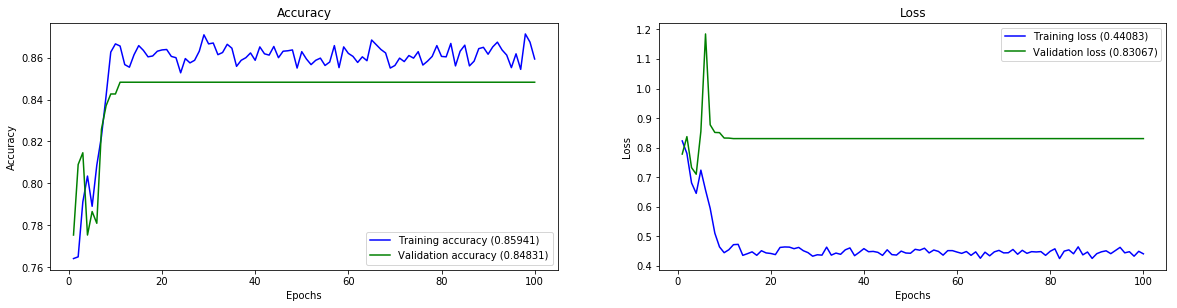

peak memory: 4949.22 MiB, increment: 0.73 MiB
CPU times: user 721 ms, sys: 605 ms, total: 1.33 s
Wall time: 752 ms


In [156]:
%%time
%%memit

import matplotlib.pyplot as plt
#Plot loss and accuracy for the training and validation set.
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)

**Model Evaluation**

In [157]:
#Evaludate model use Keras reported accuracy:
score = model.evaluate(X_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(X_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(X_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

model train data score       :  91.0 %
model test data score        :  84.0 %
model validation data score  :  85.0 %


#### Prediction test 

In [158]:
print ("Prediction with [train] data")
y_pred = model.predict_classes(X_train)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_train[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(5):
    print (i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_train[i])])
    print ("")

Prediction with [train] data
  |__match    : 4416
  |__miss     : 428
  |__accuracy : 90.31 %

---samples---
0 predict = drilling
0 original= drilling

1 predict = dog_bark
1 original= dog_bark

2 predict = jackhammer
2 original= jackhammer

3 predict = street_music
3 original= street_music

4 predict = engine_idling
4 original= street_music



In [159]:
# prediction class 
print ("Prediction with [test] data")
y_pred = model.predict_classes(X_test)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_test[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(8):
    print (i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_test[i])])
    print ("")

Prediction with [test] data
  |__match    : 301
  |__miss     : 59
  |__accuracy : 80.4 %

---samples---
0 predict = street_music
0 original= street_music

1 predict = street_music
1 original= street_music

2 predict = street_music
2 original= street_music

3 predict = engine_idling
3 original= engine_idling

4 predict = air_conditioner
4 original= air_conditioner

5 predict = children_playing
5 original= street_music

6 predict = street_music
6 original= street_music

7 predict = jackhammer
7 original= jackhammer



In [160]:
# prediction class 
print ("Prediction with [validation] data")
y_pred = model.predict_classes(X_val)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_val[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(8):
    print (i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_val[i])])
    print ("")

Prediction with [validation] data
  |__match    : 151
  |__miss     : 27
  |__accuracy : 82.12 %

---samples---
0 predict = dog_bark
0 original= car_horn

1 predict = air_conditioner
1 original= air_conditioner

2 predict = car_horn
2 original= car_horn

3 predict = street_music
3 original= street_music

4 predict = siren
4 original= siren

5 predict = dog_bark
5 original= dog_bark

6 predict = air_conditioner
6 original= air_conditioner

7 predict = children_playing
7 original= children_playing



#### Prepcare  Submission

In [161]:
print ("test data size ",len(test_audio_data))
sub_test = test_audio_data[1:22]
tx_test, ty_test = zip(*test_audio_data)

# make prediction 
tx_test2 = np.array([x.reshape((128, 128, 1)) for x in tx_test])
print ("test data shape ", tx_test2.shape)

test data size  3297
test data shape  (3297, 128, 128, 1)


In [162]:
# run prediction data
y_pred = model.predict_classes(tx_test2, batch_size=1)
print ( len(y_pred), len(tx_test2))

3297 3297


In [163]:
# save result for submission
prediction_output_file='prediction_result_1.csv'
with open(prediction_output_file,"w") as file:
    file.write("ID,Prediction\n") 
    i=0
    for i in range( (len(valid_test_data)-1)) :
        #print(i, y_pred[i])
        file.write(str(valid_test_data['ID'][i])+','+ int_to_label[y_pred[i]])
        file.write('\n')
        i=i+1
        
print (len(y_pred))
output = pd.read_csv(prediction_output_file)
output.head(20)

3297


,ID,Prediction
0,5,jackhammer
1,7,dog_bark
2,8,drilling
3,9,dog_bark
4,13,street_music
5,14,drilling
6,16,air_conditioner
7,21,dog_bark
8,23,dog_bark
9,25,drilling


### Data Augmentation
Data augumentation help improve model performance on unseen data. However, it takes sometimes to finish. Result will show if this effort worth the extra time.

#### 1. Vary Time

In [132]:
!mkdir -p augmented_train

In [133]:
# Sample first
import os
sample1=TRAIN_AUDIO_DIR+'/0.wav'
y, sr = librosa.load(sample1, duration=2.97)
y_changed = librosa.effects.time_stretch(y, rate=0.81)
directory="./augmented_train"
if not os.path.exists(directory):
    os.makedirs(directory)
librosa.output.write_wav(directory+'/vary_time_sample1.wav' ,y_changed, sr)

In [134]:
# sample-1: audio augmented with vary time
import IPython.display as ipd
ipd.Audio(sample1) 

In [135]:
!mkdir -p augmented_train/vary_time

In [136]:
%%time
%%memit
import os
rate = 1.07 # replace with other value then execute again
directory="./augmented_train/vary_time"

if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TEST data from audio files")
else:
    print ("reloading TEST data from audio files")
    for row in valid_train_data.itertuples():
        y, sr = librosa.load(row.path, duration=2.97)      
        y_changed = librosa.effects.time_stretch(y, rate=rate)
        if not os.path.exists(directory):
            os.makedirs(directory)    
        librosa.output.write_wav(directory+ '/' + str(row.ID)+".wav" ,y_changed, sr)

reloading TEST data from audio files


Process MemTimer-24:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/workdisk/gpupy3env/lib/python3.6/site-packages/memory_profiler.py", line 233, in run
    stop = self.pipe.poll(self.interval)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt


KeyboardInterrupt: 

#### 2. Vary pitch

In [137]:
!mkdir -p augmented_train/vary_pitch

In [138]:
%%time
%%memit
n_steps = 2 #-1, -2, 2, 1
sr=22050
directory="./augmented_train/vary_pitch"
if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TEST data from audio files")
else:
    print ("reloading TEST data from audio files")
    for row in valid_train_data.itertuples():
        y, sr = librosa.load(row.path, duration=2.97)      
        y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
        if not os.path.exists(directory):
            os.makedirs(directory)    
        librosa.output.write_wav(directory + '/' + str(row.ID)+".wav" ,y_changed, sr)

reloading TEST data from audio files


Process MemTimer-25:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/workdisk/gpupy3env/lib/python3.6/site-packages/memory_profiler.py", line 233, in run
    stop = self.pipe.poll(self.interval)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt


KeyboardInterrupt: 

#### 3. Change Pitch (PS2)

In [ ]:
!mkdir -p augmented_train/vary_pitch2

In [ ]:
%%time
%%memit
n_steps = 2.5 #-2.5, -3.5, 2.5, 3.5
sr=22050
directory="./augmented_train/vary_pitch2"    

if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TEST data from audio files")
else:
    print ("reloading TEST data from audio files")
    for row in valid_train_data.itertuples():
        y, sr = librosa.load(row.path, duration=2.97)      
        y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
        if not os.path.exists(directory):
            os.makedirs(directory)    
        librosa.output.write_wav( directory+ '/' + str(row.ID)+".wav" ,y_changed, sr)

#### Load augmented audio files into training

In [ ]:
#load vary_time into training data
#if SKIP_AUDIO_RELOAD is True:
#    print ("skip re-loading TRAINING data from audio files")
#else:
print ("loading augmented_train - vary_time audio data. please wait!")
directory="augmented_train/vary_time/"

if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TEST data from audio files")
else:
    print ("reloading TEST data from audio files")
    for row in tqdm(valid_train_data.itertuples()):
        ps = load_audio_file(directory+str(row.ID)+".wav", duration=2.97)
        if ps.shape != (128, 128): continue
        train_audio_data.append( (ps, row.Class) ) 
    print("Number of train samples: ", len(train_audio_data))

In [ ]:
print ("loading augmented_train - vary_pitch audio data. please wait!")
directory="./augmented_train/vary_pitch/"

if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TEST data from audio files")
else:
    print ("reloading TEST data from audio files")
    for row in tqdm(valid_train_data.itertuples()):
        ps = load_audio_file(directory+str(row.ID)+".wav", duration=2.97)
        if ps.shape != (128, 128): continue
        train_audio_data.append( (ps, row.Class) ) 
    print("Number of train samples: ", len(train_audio_data))

In [ ]:
print ("loading augmented_train - vary_time2 audio data. please wait!")
directory="./augmented_train/vary_pitch2/"

if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TEST data from audio files")
else:
    print ("reloading TEST data from audio files")
    for row in tqdm(valid_train_data.itertuples()):
        ps = load_audio_file(directory+str(row.ID)+".wav", duration=2.97)
        if ps.shape != (128, 128): continue
        train_audio_data.append( (ps, row.Class) ) 
    print("Number of train samples: ", len(train_audio_data))

In [ ]:
# load saved data
#if SKIP_AUDIO_RELOAD is True:
#    test_audio_data = cPickle.load(open(train_augm_object_file, 'rb'))
#    print ("loaded test data [%s] records from object file" % len(test_audio_data))      
#else:
#cPickle.dump(train_audio_data, open(train_augm_object_file, 'wb')) 
#print ("save augment train data :", len(train_audio_data))

train_augm_object_file='saved__augm_train_audio_data-1.p'

# load saved data
if SKIP_AUDIO_RELOAD is True:
    test_audio_data = cPickle.load(open(train_augm_object_file, 'rb'))
    print ("loaded train data [%s] records from object file" % len(test_audio_data))      
else:
    cPickle.dump(test_audio_data, open(train_augm_object_file, 'wb')) 
    print ("save loaded test data :", len(train_audio_data))

The dataset consists of:
- 1-7467 normal samples.
- 7468-14934 samples Pitch modulated 2.5 semitones higher.
- 14935-22401 samples Pitch modeulated 2 semitones higher.
- 22402-29869 samples Slowed down to 0.81.
- 29869-37310 samples speed up by 1.07

Follow the same procedure for the normal data.

#### Load all normal record +  changed records

In [139]:
dataset = train_audio_data
random.shuffle(dataset)

#full dataset
dataset = train_audio_data
random.shuffle(dataset)

RATIO=0.9
train_cutoff= round(len(dataset) * RATIO)
train = dataset[:train_cutoff]
test = dataset[train_cutoff:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

print ("train ",X_train.shape, len(y_train))
print ("test ", X_test.shape, len(y_test))

train  (4844, 128, 128, 1) 4844
test  (538, 128, 128, 1) 538


In [140]:
# Apply sck-learn label text encoding to integer
label_encoder = LabelEncoder()
y_train_integer_encoded = label_encoder.fit_transform(y_train)
y_test_integer_encoded = label_encoder.fit_transform(y_test)

# Apply Keras One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train_integer_encoded, len(list_labels)))
y_test = np.array(keras.utils.to_categorical(y_test_integer_encoded, len(list_labels)))

#split up test into test and validation 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

print ("test ",X_test.shape, len(y_test))
print ("valid ", X_val.shape, len(y_val))


test  (360, 128, 128, 1) 360
valid  (178, 128, 128, 1) 178


In [141]:
# build convolution model
model = Sequential()
input_shape=(128, 128, 1)  

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(len(list_labels)))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 124, 24)      624       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 62, 24)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 31, 62, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 58, 48)        28848     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 29, 48)         0         
_________________________________________________________________
activation_7 (Activation)    (None, 6, 29, 48)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 25, 48)         57648     
__________

In [142]:
%%time
%%memit

MAX_EPOCHS=63
MAX_BATCH_SIZE=23   
# reducing batch size from 128 to 32/24 improve accuracy from 50% to 85%
MAX_PATIENT=1

# saved model checkpoint file
best_model_file="./best_model_trained2.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

#compile
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=['accuracy'])

#train
print('training started....:')
history = model.fit(x=X_train, y=y_train,
                    epochs=MAX_EPOCHS,
                    batch_size=MAX_BATCH_SIZE, 
                    verbose=0,
                    validation_data= (X_val, y_val), 
                    callbacks=callback)
print('training finished')

#evaludate model
print('Evaluate model with test data')
score = model.evaluate(x=X_test,y=y_test)

print('test loss:', score[0])
print('test accuracy:', score[1])

training started....:

Epoch 00001: loss improved from inf to 2.46548, saving model to ./best_model_trained2.hdf5

Epoch 00002: loss improved from 2.46548 to 1.92285, saving model to ./best_model_trained2.hdf5

Epoch 00003: loss improved from 1.92285 to 1.73304, saving model to ./best_model_trained2.hdf5

Epoch 00004: loss improved from 1.73304 to 1.55056, saving model to ./best_model_trained2.hdf5

Epoch 00005: loss improved from 1.55056 to 1.40715, saving model to ./best_model_trained2.hdf5

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00006: loss improved from 1.40715 to 1.35731, saving model to ./best_model_trained2.hdf5

Epoch 00007: loss improved from 1.35731 to 1.20903, saving model to ./best_model_trained2.hdf5

Epoch 00008: loss improved from 1.20903 to 1.11283, saving model to ./best_model_trained2.hdf5

Epoch 00009: loss improved from 1.11283 to 1.08006, saving model to ./best_model_trained2.hdf5

Epoch 00010: loss improved from 1.0

In [143]:
#Evaludate model use Keras reported accuracy:
score = model.evaluate(X_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(X_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(X_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

model train data score       :  74.0 %
model test data score        :  70.0 %
model validation data score  :  72.0 %


<Figure size 1584x720 with 0 Axes>

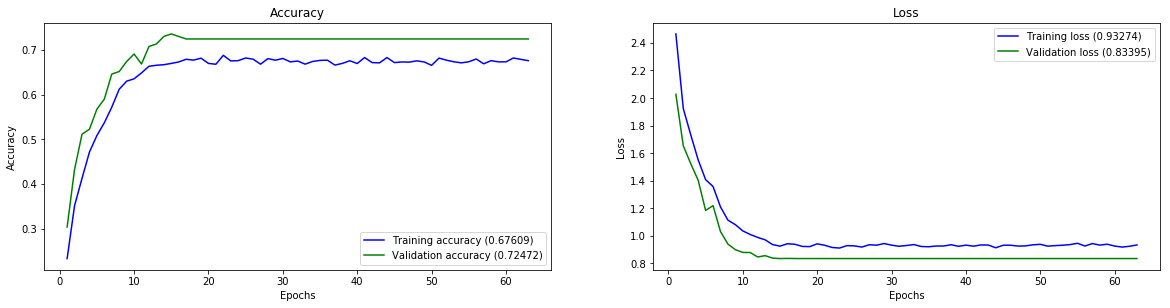

In [144]:
# plot history
plot_history(history)

Making predictions and writing it to CSV

In [146]:
# prediction class 
print ("Prediction with test data")
y_pred = model.predict_classes(X_test)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_test[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")
#print ("missed : \n",missed)

Prediction with test data
  |__match    : 253
  |__miss     : 107
  |__accuracy : 57.71 %



In [147]:
# run prediction data
tx_test, ty_test = zip(*test_audio_data)

# make prediction 
tx_test2 = np.array([x.reshape((128, 128, 1)) for x in tx_test])

y_pred = model.predict_classes(tx_test2, batch_size=22)
print ( len(y_pred), len(tx_test2))
print (len(valid_test_data))

3297 3297
3297


In [ ]:

# save result for submission
prediction_output_file='prediction_result.csv'
with open(prediction_output_file,"w") as file:
    file.write("ID,Prediction\n") 
    i=0
    for i in range( (len(valid_test_data)-1)) :
        #print(i, y_pred[i])
        file.write(str(valid_test_data['ID'][i])+','+ int_to_label[y_pred[i]])
        file.write('\n')
        i=i+1

print (len(y_pred))
output = pd.read_csv(prediction_output_file)
output.head(20)

With data augmentation, model prediction accurancy has increased.

That is it for now, drop any comment or suggestion.  Vote up if you find it useful. 

thanks  - Min yang